### Moodboard generation

In [1]:
# Necessary imports - done
# -------------------------

import os
from PIL import Image
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import copy
import cv2
from os import listdir
from os.path import isfile, join
import h5py
import time
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import pandas as pd
import math
import Augmentor
#import webcolors
import sys
from tqdm import tqdm

import torch
from torch.autograd import Variable
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.utils import save_image
import torch.optim as optim

from __future__ import print_function
import scipy
from scipy.ndimage import filters
from PIL import Image

from scipy import misc
from io import BytesIO
from selenium.webdriver.common.keys import Keys
import selenium
import bs4
from bs4 import BeautifulSoup
import urllib
from urllib.request import urlopen
import urllib.request
from urllib.request import Request
import requests
import shutil
import ssl
import httplib2
from selenium import webdriver
import lxml
import json
from selenium.webdriver.firefox.options import Options
import multiprocessing



%matplotlib inline
%env JOBLIB_TEMP_FOLDER=/tmp



# importing vgg16
# ---------------
#import torchvision.models as models
#vgg16 = models.vgg16(pretrained=True)

#%matplotlib inline

/Users/venkateshmadhava/Documents/pmate2/pmate2_env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: JOBLIB_TEMP_FOLDER=/tmp


# 1. codes - helper functions

In [2]:
# Helper functions
# ----------------

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name



# usage 
# -----
#requested_colour = (186, 21, 79)
#actual_name, closest_name = get_colour_name(requested_colour)
#actual_name, closest_name

#c = np.zeros((1,1,3), dtype = 'uint8')
#c[:,:,:] = requested_colour
#plt.imshow(c)



# SIMPLE FUNTION TO CONVERT RGB TO GRAYSCALE
# -------------------------------------------
def rgb2gray(x):
    

    x[:,:,:,0] = x[:,:,:,0] * 0.2989
    x[:,:,:,1] = x[:,:,:,0] * 0.5870
    x[:,:,:,2] = x[:,:,:,0] * 0.1140
    xout = np.sum(x,axis = 3)
    

    #r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return xout


def converttoh5(data,data_label,y,y_label,outputurl):
    
    # h5 file creation
    # ----------------
    # outputurl must be = folder + '/' + filename.h5
    hf = h5py.File(outputurl, 'w')
    hf.create_dataset(data_label, data = data, dtype = 'uint8')
    hf.create_dataset(y_label, data = y)
    print('Done.')
    hf.close()

    
def readfromh5(inurl,data_label,y_label):
    
    # reading from h5
    # ---------------
    hfr = h5py.File(inurl, 'r')
    data = np.array(hfr.get(data_label))
    y = np.array(hfr.get(y_label))
    return data, y



# Takes as input y of dimension (m) and starts with rating 1
# ----------------------------------------------------------

def generate_one_hot_y(yin):
    
    # Snippet
    # -------
    m = yin.shape[0]
    c = np.max(yin) + 1
    
    
    y = np.zeros((m,c))
    y[np.arange(len(y)), yin.astype('int')] = 1
    
    return y


# Function to return indices
# --------------------------
def split_sets(total_len, train_per, val_per):
    
    # 1. initialisations
    # ------------------
    trn_size = int(train_per * total_len)
    val_size = int(val_per * total_len)
    test_size = total_len - trn_size - val_size
    assert trn_size + val_size + test_size == total_len

    # 2. train set indices
    # ---------------------
    trn_strt = 0
    trn_end = trn_strt + trn_size
    
    # 3. val set indices
    # ------------------
    val_strt = trn_end
    val_end = val_strt + val_size
    
    # 4. train set indices
    # --------------------
    test_strt = val_end
    test_end = total_len
    
    return trn_strt,trn_end,val_strt,val_end,test_strt,test_end


# simple function to read a single image
# --------------------------------------
def pick_img_from_folder(infolder,resize,new_h,new_w):
    
    
    # 0. Initialisations
    # ------------------
    image_list = [f for f in listdir(infolder) if isfile(join(infolder, f)) and '.jpg' in f]
    counter = 0
    
    # 1. sanity assertion
    # -------------------
    assert len(image_list) > 0, 'No images in the folder'
    
    
    # 2. reading image
    # ----------------
    for name in image_list:

        # reading image ops
        # -----------------
        counter += 1
        img = cv2.imread(join(infolder, name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if resize == True:
            img = cv2.resize(img, (new_w,new_h))
        img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
        
        # concat ops
        # ----------
        try:
            xout = np.concatenate((xout,img), axis = 0)
        except:
            xout = np.zeros((0,img.shape[1],img.shape[2],img.shape[3]), dtype = 'uint8')
            xout = np.concatenate((xout,img), axis = 0)
        
        print('\rDone with image ' + str(counter) + ' of around ' + str(len(image_list)) + '..', end = '')
    
    # final return
    # ------------
    return xout
    

In [3]:
# saves many arrays into single h5
# ---------------------------------

def converttoh5_many(l,outputurl):
    
    '''
    
    list must be [(label,data_array),(label,data_array),...]
    
    '''
    
    # h5 file creation
    # outputurl must be = folder + '/' + filename.h5
    # ----------------------------------------------
    hf = h5py.File(outputurl, 'w')
    
    # iterating over objects
    # ----------------------
    for each in l:
        
        curr_label = each[0]
        curr_data = each[1]
        
        # checking if input is image
        # --------------------------
        if len(curr_data.shape) == 4:
            hf.create_dataset(curr_label, data = curr_data, dtype = 'uint8')
        else:
            hf.create_dataset(curr_label, data = curr_data)
    
    # closure
    # -------
    print('Done.')
    hf.close()

In [4]:
# function to take in folder and output numpy array of images
# -----------------------------------------------------------

def create_single_h5(infolder,save_location,save_filename,new_h,new_w):
    
    # 0. Initialisations
    # ------------------
    d = {}
    counter = 0
    image_list = [f for f in listdir(infolder) if isfile(join(infolder, f)) and '.jpg' in f]
 
    
    # 1. iteration
    # ------------
    for name in image_list:
        counter += 1
        print('reading and saving image ' + str(counter) + ' of around ' + str(len(image_list)) + ' images..')
        img = cv2.imread(join(infolder, name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (new_w,new_h))
        img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
        
        try:
            x_imgs = np.concatenate((x_imgs,img), axis = 0)
            img_name_int = int(name.replace('.jpg',''))
            skus = np.concatenate((skus,np.array(([img_name_int])).reshape(1,1)), axis = 0)
        
        except:
            # creating new arrays
            # -----------------
            x_imgs = np.zeros((0,img.shape[1],img.shape[2],img.shape[3]),  dtype='uint8')
            skus = np.zeros((0,1), dtype = 'int')
            
            # concatenating
            # -------------
            x_imgs = np.concatenate((x_imgs,img), axis = 0)
            img_name_int = int(name.replace('.jpg',''))
            skus = np.concatenate((skus,np.array(([img_name_int])).reshape(1,1)), axis = 0)
    
        #d[name] = img
    
    # 2. converting dict as numpy array
    # access image using syntax nparray[()]['key']
    # dictionary is d['imagename'] = img_array
    # access dictionary d - nparray[()]
    # images stored in (h,w,3) form not (1,h,w,3)
    # --------------------------------------------
    #np_d = np.array(d)
    
    # 3.saving ops pf the np.array using np.save
    # save location must be folder/filename.npy
    # load at otherend using np.load(url) method
    # ------------------------------------------
    #np.save(save_location,np_d)
    
    # 3. Using h5 to save and read files since 
    # np.save will not save data above 4GB it seems
    # outputurl must be = folder + '/' + filename.h5
    # ---------------------------------------------
    save_filename = save_location + '/' + save_filename
    converttoh5(x_imgs,skus,save_filename)
    
   
    
    

In [5]:
# a generic function that creates a pair of datastes
# --------------------------------------------------


def create_pair_datasets(mainurl,masterurl,new_h,new_w):
    
    '''
    creates a pair of datasets by going through images in mainurl and grabbing the image by same name
    in master url
    
    '''
    
    
    # 0. Initialisations
    # ------------------
    counter = 0
    image_list = [f for f in listdir(mainurl) if isfile(join(mainurl, f)) and '.jpg' in f]
    image_list_master = [f for f in listdir(masterurl) if isfile(join(masterurl, f)) and '.jpg' in f]    
    
    # 1. iteration
    # ------------
    for name in image_list:
        
        # image ops
        # ---------
        counter += 1
        print('At image ' + str(counter) + ' of around ' + str(len(image_list)) + ' images..')
        
        # working on the image only if its found in its master folder
        # -----------------------------------------------------------
        if name in image_list_master:
            
            img = cv2.imread(join(mainurl, name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (new_w,new_h))
            img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
            
            img_master = cv2.imread(join(masterurl, name))
            img_master = cv2.cvtColor(img_master, cv2.COLOR_BGR2RGB)
            img_master = cv2.resize(img_master, (new_w,new_h))
            img_master = img_master.reshape(1,img_master.shape[0],img_master.shape[1],img_master.shape[2])
            
            

            try:

                # direct concat
                # -------------
                x_imgs_main = np.concatenate((x_imgs_main,img), axis = 0)
                x_imgs_master = np.concatenate((x_imgs_master,img_master), axis = 0)

            except:

                # creating new arrays
                # -----------------
                x_imgs_main = np.zeros((0,img.shape[1],img.shape[2],img.shape[3]),  dtype='uint8')
                x_imgs_master = np.zeros((0,img_master.shape[1],img_master.shape[2],img_master.shape[3]),  dtype='uint8')
                
                # concat ops
                # ----------
                x_imgs_main = np.concatenate((x_imgs_main,img), axis = 0)
                x_imgs_master = np.concatenate((x_imgs_master,img_master), axis = 0)
        
        
        
    # final return
    # ------------
    return x_imgs_main, x_imgs_master
                
            

In [6]:
# function to take in folder and output numpy array of images
# -----------------------------------------------------------

def create_single_h5_generic(infolder,save_location,save_filename,new_h,new_w,classes):
    
    # 0. Initialisations
    # ------------------
    d = {}
    counter = 0
    image_list = [f for f in listdir(infolder) if isfile(join(infolder, f)) and '.jpg' in f]
    number_of_classes = len(classes)
    
    
    # 1. iteration
    # ------------
    for name in image_list:
        
        # image ops
        # ---------
        counter += 1
        print('reading and saving image ' + str(counter) + ' of around ' + str(len(image_list)) + ' images..')
        img = cv2.imread(join(infolder, name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (new_w,new_h))
        img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
        
        try:
            
            # direct concat
            # -------------
            x_imgs = np.concatenate((x_imgs,img), axis = 0)
         
        except:
            
            # creating new arrays
            # -----------------
            x_imgs = np.zeros((0,img.shape[1],img.shape[2],img.shape[3]),  dtype='uint8')
            y = np.zeros((0,number_of_classes), dtype = 'int')
            
            # concatenating
            # -------------
            x_imgs = np.concatenate((x_imgs,img), axis = 0)
        
        
        # Building y - one hot - Outside try & except
        # -------------------------------------------
        for c in classes:
            if c in name:
                y_ind = classes.index(c)

        y_curr = np.zeros((1,number_of_classes), dtype = 'int')
        y_curr[0,y_ind] = 1
        y = np.concatenate((y,y_curr), axis = 0)
    
  
    # 3. Using h5 to save and read files since 
    # np.save will not save data above 4GB it seems
    # outputurl must be = folder + '/' + filename.h5
    # converttoh5(data,data_label,y,y_label,outputurl)
    # ---------------------------------------------
    save_filename = save_location + '/' + save_filename
    converttoh5(x_imgs,'images',y,'y',save_filename)
    
    
   
    
    

In [7]:
# specific code to build dataset from folder and a csv
####

def create_h5_from_csv(csv_url,infolder,new_h,new_w,save_filename):
    
    '''
    
    INPUT HERE MUST BE ['IMAGE_NAME','RATING'] ARRAY
    
    '''

    # 1. read the csv
    # ---------------
    df = pd.read_csv(csv_url)
    df = df
    np_df = df.values
    number_of_classes = np.max(np_df[:,1])
    counter = 0

    # 2. setting up y
    # ---------------
    #y_raw = np_df[:,1] - 1 # since the rating starts with 1
    #y_one_hot = generate_one_hot_y(y_raw)

    # 3. Itering over images and setting up h5 files
    # ----------------------------------------------
    for i in range(np_df.shape[0]):
        
        # input must always be of this format
        # -----------------------------------
        curr_name = np_df[i,0]
        curr_rating = int(np_df[i,1]) - 1
        
        
        # image ops
        # ---------
        counter += 1
        print('reading and saving image ' + str(counter) + ' of around ' + str(np_df.shape[0]) + ' images..')
        
        try:
            
            img = cv2.imread(join(infolder, curr_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (new_w,new_h))
            img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
        
            try:
                
                # direct concat
                # -------------
                x_imgs = np.concatenate((x_imgs,img), axis = 0)
                
            except:

                # creating new arrays
                # -----------------
                x_imgs = np.zeros((0,img.shape[1],img.shape[2],img.shape[3]),  dtype='uint8')
                y = np.zeros((0,number_of_classes), dtype = 'int')

                # concatenating
                # -------------
                x_imgs = np.concatenate((x_imgs,img), axis = 0)
                
                
            # Setting up y
            # ------------
            y_curr = np.zeros((1,number_of_classes), dtype = 'int')
            y_curr[0,curr_rating] = 1
            y = np.concatenate((y,y_curr), axis = 0)
        
        except:
            
            # this means that the image is not read from URL, we will just skip this
            # ----------------------------------------------------------------------
            pass
        
        

    # Splitting train, val and test data
    # ----------------------------------
    tr_s, tr_e, val_s, val_e, test_s, test_e = split_sets(x_imgs.shape[0], 0.75, 0.15)
    
    # train set
    ##
    ximg_train = x_imgs[tr_s:tr_e]
    y_train = y[tr_s:tr_e]
    
    # val set
    ##
    ximg_val = x_imgs[val_s:val_e]
    y_val = y[val_s:val_e]
    
    # test set
    ##
    ximg_test = x_imgs[test_s:test_e]
    y_test = y[test_s:test_e]
    
    input_list = [('train_images', ximg_train), 
                  ('train_y', y_train),
                  ('val_images', ximg_val),
                  ('val_y', y_val),
                  ('test_images', ximg_test),
                  ('test_y', y_test)
                 ]
    
    
    
    
    # 4. Using h5 to save and read files since 
    # np.save will not save data above 4GB it seems
    # outputurl must be = folder + '/' + filename.h5
    # converttoh5(data,data_label,y,y_label,outputurl)
    # ------------------------------------------------
    converttoh5_many(input_list,save_filename)
        
        


In [8]:
# simple function to read a single image
# --------------------------------------
def create_dataset_from_folder_all(infolder,resize,n_h,n_w):
    
    # 0. global initialisations
    # -------------------------
    global resize_flag
    resize_flag = resize
    
    global gb_in_folder
    gb_in_folder = infolder

    global counter
    counter = 0
    
    global new_h
    new_h = n_h
    
    global new_w
    new_w = n_w

    global image_list
    image_list = [f for f in listdir(infolder) if isfile(join(infolder, f)) and '.jpg' in f]
    
    global x_images_dataset
    x_images_dataset = np.zeros((len(image_list),new_h,new_w,3), dtype='uint8')
    
    # 1.1 sanity assertion
    # -------------------
    assert len(image_list) > 0, 'No images in the folder'
    
    
    # 2. calling resize function across multiprocessing pool
    # ------------------------------------------------------
    pool = ThreadPool(5) 
    pool.map(create_dataset_from_folder_single, list(range(len(image_list))))
    print('Done creating dataset of around ' + str(counter) + ' images. Access them at global x_images_dataset.')

    
    
    
    
    
    
def create_dataset_from_folder_single(i):
    
    # 0. calling global variables
    # ---------------------------
    global gb_in_folder
    global counter
    global new_h
    global new_w
    global x_images_dataset
    global image_list
    global resize_flag
    
    
    # 1. ops
    # ------
    name = image_list[i]
    img = cv2.imread(join(gb_in_folder, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize_flag == True:
        img = cv2.resize(img, (new_w,new_h))
    #img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    x_images_dataset[i] = img
    counter += 1
    


In [9]:
## Functions to resize batch images
## --------------------------------


# FUNCTION 1
# GENERIC FUNCTION TO RESIZE A NUMPY ARRAY OF IMAGES
# ---------------------------------------------------

def resize_all(ximgs,n_h,n_w):
    
    # 1. global initialisations
    # -------------------------
    global x_img_loop
    x_img_loop = ximgs

    global counter
    counter = 0
    
    global new_h
    new_h = n_h
    
    global new_w
    new_w = n_w
    
    global x_images_resized
    x_images_resized = np.zeros((x_img_loop.shape[0],new_h,new_w,3), dtype='uint8')
    
    # 2. calling resize function across multiprocessing pool
    # ------------------------------------------------------
    pool = ThreadPool(5) 
    pool.map(resize_image, list(range(x_img_loop.shape[0])))
    print('Done resizing ' + str(counter) + ' images.')

    
# FUNCTION 2
# GENERIC FUNCTION - to resize a single image
# ------------------------------------------
def resize_image(i):
    
    # global variables
    # ----------------
    global x_img_loop
    global x_images_resized
    global counter
    global new_h
    global new_w
    
    # 1. resizing loop
    # ----------------
    img = x_img_loop[i]
    img = cv2.resize(img, (new_w,new_h))
    x_images_resized[i] = img
    counter += 1

    
# FUNCTION 3
# SIMPLE function to show random orig and resized images
# ------------------------------------------------------
def show_resized_images(xorig, xres, no_samples):
    
    # 1. random list initiailisation
    # ------------------------------
    l = [random.randint(0, xorig.shape[0]) for p in range(0, no_samples)]

    # 2. looping
    # ----------
    for i in l:
        print(str(i))
        print('original..')
        plt.imshow(xorig[i])
        plt.show()
        print('resized...')
        plt.imshow(xres[i])
        plt.show()
        print('\n---------\n')

In [10]:
# need a way to centre crop image
# --------------------------------

def center_crop(x,width_percent):
    
    
    # 0.initialisations
    # -----------------
    m,h,w,c = x.shape
    w_to_crop = int(width_percent*w)

    # 1. working out width
    # --------------------
    w_to_h_ratio = h/w
    mid_w = int(w/2)
    w_to_crop_half = int(w_to_crop/2)
    w_strt = mid_w - w_to_crop_half
    w_end = mid_w + w_to_crop_half

    # 2. working on height
    # ---------------------
    mid_h = int(h/2)
    h_to_crop = int(w_to_h_ratio * w_to_crop)
    h_to_crop_half = int(h_to_crop/2)
    h_strt = mid_h - h_to_crop_half
    h_end = mid_h + h_to_crop_half
    
    # 3. Setting up output
    # --------------------
    xout = x[:,h_strt:h_end,w_strt:w_end,:]
    
    
    # 4. finally resizing the xout
    # ----------------------------
    resize_all(xout,h,w)
    global x_images_resized
    
    
    return x_images_resized
    

In [11]:
# A simple function to return h,w,c of model out
# ----------------------------------------------

def get_model_layer_h_w(model,index,h,w,c):
    
    # 0. Initialisations
    # ------------------
    model_in = Variable(torch.zeros((2,c,h,w))).float()
    model_part = nn.Sequential(*list(model)[0:index])
    model_out = model_part(model_in)
    om,oc,oh,ow = model_out.size()
    
    # printing result
    # ---------------
    print('At layer ' + str(index) + ', dims are - ')
    print('Height - ' + str(oh))
    print('Width - ' + str(ow))
    print('Channels - ' + str(oc))


In [12]:
# function that delivers pointwise and vgg latents
# ------------------------------------------------

def deliver_latents(in_mode,x_in,in_url,fcnae_net,fcnae_h,fcnae_w,fcnae_use_grayscale,use_cuda,print_images):
    
    
    
    ''' NO POINTWISE COLORMAP STUFF HERE '''
    
    
    # 1. getting fcn latent
    # ---------------------
    print('1. Setting up data for fcn ae ops..')
    if in_mode == 'folder':
        create_dataset_from_folder_all(in_url,True,fcnae_h,fcnae_w)
        global x_images_dataset
        x_fcn = x_images_dataset
    else:
        x_fcn = x_in
    

    # 2. gray scale ops if required
    # -----------------------------
    if fcnae_use_grayscale == True:
        
        # gray scale ops
        # --------------
        x_fcn_final = rgb2gray(copy.deepcopy(x_fcn))
        mas_m, mas_h, mas_w = x_fcn_final.shape
        x_fcn_final = x_fcn_final.reshape(mas_m, mas_h, mas_w, 1)
        x_fcn_final = np.concatenate((x_fcn_final,x_fcn_final,x_fcn_final), axis = 3).astype('uint8')

    elif fcnae_use_grayscale == 'both':
        
        # gray scale ops
        # --------------
        x_fcn_final_gray = rgb2gray(copy.deepcopy(x_fcn))
        mas_m, mas_h, mas_w = x_fcn_final_gray.shape
        x_fcn_final_gray = x_fcn_final_gray.reshape(mas_m, mas_h, mas_w, 1)
        x_fcn_final_gray = np.concatenate((x_fcn_final_gray,x_fcn_final_gray,x_fcn_final_gray), axis = 3).astype('uint8')
        
        # color ops
        # ---------
        x_fcn_final_colour = copy.deepcopy(x_fcn)
        x_fcn_final = copy.deepcopy(x_fcn)
    
    else:
        # keep it the same
        # ----------------
        x_fcn_final = copy.deepcopy(x_fcn)

    
    
    # 2.1 printing images if required
    # -------------------------------
    if print_images == True:
        print('>> showing input data before fcn ae inference..')
        randrange = list(np.random.randint(x_fcn.shape[0], size=(1, 2))[0,:])
        for i in randrange:
            print(str(i))
            plt.imshow(x_fcn_final[i])
            plt.show()
            print('----------------')
    
    
    
    # 3. Getting latents
    # ------------------
    if fcnae_use_grayscale == 'both':
        
        # 1. gray scale op
        # ----------------
        print('1. getting grayscale latent..')
        latent_fcnae_gray = chunk_pass(Variable(setup_image_tensor(x_fcn_final_gray)).float(),fcnae_net,True,use_cuda,1)
        
        # 2. color latent
        # ---------------
        print('2. getting colour set latent..')
        latent_fcnae_col = chunk_pass(Variable(setup_image_tensor(x_fcn_final_colour)).float(),fcnae_net,True,use_cuda,1)
        
        # 3. concat
        # ---------
        latent_fcnae = torch.cat((latent_fcnae_gray, latent_fcnae_col), 1)
        
    else:
        
        latent_fcnae = chunk_pass(Variable(setup_image_tensor(x_fcn_final)).float(),fcnae_net,True,use_cuda,1)
        print(latent_fcnae.size())
    
    
    # 4. final return
    # ---------------
    return latent_fcnae.data.cpu().numpy(), x_fcn_final
    


In [13]:
# function that delivers pointwise and vgg latents
# ------------------------------------------------

def deliver_latents_older_version(in_url,cen_crop,cen_crop_val,pwise_net,pwise_h,pwise_w,fcnae_net,fcnae_h,fcnae_w,fcnae_use_grayscale,use_cuda):
    

    # 1. getting pointwise
    # --------------------
    print('1. Setting up data for pointwise ops..')
    create_dataset_from_folder_all(in_url,True,pwise_h,pwise_w)
    global x_images_dataset
    x_pwise_prior = x_images_dataset
    
    # 1.1 cen crop ops
    # ----------------
    if cen_crop == True:
        x_pwise = center_crop(copy.deepcopy(x_pwise_prior),cen_crop_val)
    else:
        x_pwise = copy.deepcopy(x_pwise_prior)
    
    # 1.2 showing data
    # ----------------
    print('>> showing input data before pointwise inference..')
    randrange = list(np.random.randint(x_pwise.shape[0], size=(1, 2))[0,:])
    for i in randrange:
        print(str(i))
        plt.imshow(x_pwise[i])
        plt.show()
        print('----------------')
    
    latent_pwise = chunk_pass(Variable(setup_image_tensor(x_pwise)).float(),pwise_net,True,use_cuda,1)
    print(latent_pwise.size())
    
    # 2. getting fcn latent
    # ---------------------
    print('2. Setting up data for fcn ae ops..')
    create_dataset_from_folder_all(in_url,True,fcnae_h,fcnae_w)
    global x_images_dataset
    x_fcn_prior = x_images_dataset
    
    # 2.1 cen crop ops
    # ----------------
    if cen_crop == True:
        x_fcn = center_crop(copy.deepcopy(x_fcn_prior),cen_crop_val)
    else:
        x_fcn = copy.deepcopy(x_fcn_prior)
    
    
    # 2.2 gray scale
    # --------------
    if fcnae_use_grayscale == True:
        
        # gray scale ops
        # --------------
        x_fcn_final = rgb2gray(copy.deepcopy(x_fcn))
        mas_m, mas_h, mas_w = x_fcn_final.shape
        x_fcn_final = x_fcn_final.reshape(mas_m, mas_h, mas_w, 1)
        x_fcn_final = np.concatenate((x_fcn_final,x_fcn_final,x_fcn_final), axis = 3).astype('uint8')

    elif fcnae_use_grayscale == 'both':
        
        # gray scale ops
        # --------------
        x_fcn_final_gray = rgb2gray(copy.deepcopy(x_fcn))
        mas_m, mas_h, mas_w = x_fcn_final_gray.shape
        x_fcn_final_gray = x_fcn_final_gray.reshape(mas_m, mas_h, mas_w, 1)
        x_fcn_final_gray = np.concatenate((x_fcn_final_gray,x_fcn_final_gray,x_fcn_final_gray), axis = 3).astype('uint8')
        
        # color ops
        # ---------
        x_fcn_final_colour = copy.deepcopy(x_fcn)
        x_fcn_final = copy.deepcopy(x_fcn)
    
    else:
        # keep it the same
        # ----------------
        x_fcn_final = copy.deepcopy(x_fcn)

    
    print('>> showing input data before fcn ae inference..')
    randrange = list(np.random.randint(x_fcn.shape[0], size=(1, 2))[0,:])
    for i in randrange:
        print(str(i))
        plt.imshow(x_fcn_final[i])
        plt.show()
        print('----------------')
    
    
    
    # 3. Getting latents
    # ------------------
    if fcnae_use_grayscale == 'both':
        
        # 1. gray scale op
        # ----------------
        print('1. getting grayscale latent..')
        latent_fcnae_gray = chunk_pass(Variable(setup_image_tensor(x_fcn_final_gray)).float(),fcnae_net,True,use_cuda,1)
        
        # 2. color latent
        # ---------------
        print('2. getting colour set latent..')
        latent_fcnae_col = chunk_pass(Variable(setup_image_tensor(x_fcn_final_colour)).float(),fcnae_net,True,use_cuda,1)
        
        # 3. concat
        # ---------
        latent_fcnae = torch.cat((latent_fcnae_gray, latent_fcnae_col), 1)
        
    else:
        
        latent_fcnae = chunk_pass(Variable(setup_image_tensor(x_fcn_final)).float(),fcnae_net,True,use_cuda,1)
        print(latent_fcnae.size())
    
    
    # 4. final return
    # ---------------
    return latent_pwise.data.cpu().numpy(), latent_fcnae.data.cpu().numpy(), x_fcn_prior
    


<ipython-input-13-6d9e55e64848>:38: SyntaxWarning: name 'x_images_dataset' is used prior to global declaration
  global x_images_dataset


In [14]:
# function to simply return similar images based on whole latents
# ---------------------------------------------------------------

def return_similar_images(xin,latents_xin,xrep,latents_xrep,no_suggestions,similarity_check_mode,similarity_check_threshold_value,single_input,print_result):

    '''
    
    to include latent value switch off/on ops if required
    
    '''
    
    # 1. initialisations
    # ------------------
    final_all_indices = []
    similar_products = []
    all_similarity_values = []
    epsilon = 0 # 0.0001
    
    
    # 1.2 making input as single
    # --------------------------
    if single_input == True:
        latents_xin = np.mean(latents_xin, axis = 0).reshape(1,latents_xin.shape[1])
    
    
    # 2. Finding similarity
    # ---------------------
    for i in range(latents_xin.shape[0]):

        # Finding similarity per example
        # ------------------------------
        curr_updated_f = latents_xin[i]
        
        # checking using check mode
        # -------------------------
        if similarity_check_mode == 'threshold':
            
            min_max_sim = np.minimum(curr_updated_f,latents_xrep)/(np.maximum(curr_updated_f,latents_xrep) + epsilon)
            pos_flags = (min_max_sim > similarity_check_threshold_value).astype(int)
            min_max_sim_pos = min_max_sim * pos_flags
            position_summer = np.sum(pos_flags, axis = 1)
            values_summer = np.sum(min_max_sim_pos, axis = 1)
            similarity_array = values_summer / position_summer
        
        
        elif similarity_check_mode == 'active':
            
            curr_updated_f_active_positions = (curr_updated_f > np.mean(curr_updated_f)).astype('int')
            updated_latents_f = curr_updated_f_active_positions * curr_updated_f
            updated_latents_xrep = curr_updated_f_active_positions * latents_xrep
            similarity_array = np.average((np.minimum(updated_latents_f,updated_latents_xrep)/(np.maximum(updated_latents_f,updated_latents_xrep) + epsilon)), axis = 1)
            
        
        else:
            
            similarity_array = np.average((np.minimum(curr_updated_f,latents_xrep)/(np.maximum(curr_updated_f,latents_xrep) + epsilon)), axis = 1)

        # continuation
        # ------------
        sorted_indices = list(np.argsort(-1*similarity_array))
        final_indices = sorted_indices[0:no_suggestions]
        final_indices = [int(fi) for fi in final_indices]
        final_all_indices.append(final_indices)
        all_similarity_values.append(similarity_array[final_indices])
        similar_products.append(xrep[final_indices])
        
    
    # 3. showing if required
    # ----------------------
    if print_result == True:
        
        # itering
        # -------
        for i in range(latents_xin.shape[0]):
            
            print('>> At image ' + str(i) + ' of around ' + str(latents_xin.shape[0]) + '..')
            print('** Input Image - ')
            plt.figure(figsize=(5,5))
            plt.imshow(xin[i])
            plt.show()
            print('** Showing result images..')
            for i_1 in range(similar_products[i].shape[0]):
                print('** At image ' + str(i) + ' showing option number ' + str(i_1) + '**')
                print('Image index number: ' + str(final_all_indices[i][i_1]))
                print('Similarity value: ' + str(all_similarity_values[i][i_1]))
                plt.figure(figsize=(5,5))
                plt.imshow(similar_products[i][i_1])
                plt.show()
            
            print('\n#########################################\n')
                
            
    
    # 3. final return
    # ---------------
    return similar_products,all_similarity_values,final_all_indices

# 2. codes - colormap code

In [15]:
def recurr_kmeans(img,start_k,end_k,mode):
    
    # Initialisations
    # ---------------
    curr_im = copy.deepcopy(img)
    
    iter_flag = end_k - 1
    
    for i in range(start_k - iter_flag):
        curr_k = start_k - i
        #print('At iter ' + str(i) + ', k = ' + str(curr_k))
        if mode == 'products':
            datavec,labels,curr_im,cen = cvkmeans(curr_im,curr_k,2500,'rdatavec','pp')  # For mood boards use datavec (localised), for product images use rdatavec(centralised)
        else:
            datavec,labels,curr_im,cen = cvkmeans(curr_im,curr_k,2500,'datavec','pp')  # For mood boards use datavec (localised), for product images use rdatavec(centralised)
      
    return curr_im,cen
    

In [16]:
def cvkmeans(imn,k,iters,mode,centers):
    
    # 1. Building datavec
    # -------------------
    imageH = imn.shape[0]
    imageW = imn.shape[1]
    dataVector = np.ndarray(shape=(imageH * imageW, 5), dtype=float) # r,g,b,x,y
    imin = Image.fromarray(imn)
    
    for y in range(imageH):
        for x in range(imageW):
            #print('At ' + str(y) + ',' + str(x))
            xy = (x,y)
            rgb = imin.getpixel(xy)
            dataVector[x + y * imageW, 0] = rgb[0]
            dataVector[x + y * imageW, 1] = rgb[1]
            dataVector[x + y * imageW, 2] = rgb[2]
            dataVector[x + y * imageW, 3] = x #
            dataVector[x + y * imageW, 4] = y #

   
    
    # 2. Actual k means
    # -----------------
    if mode == 'datavec':
        kin = dataVector
    else:
        kin = imn.reshape((-1,3))
       

    # Convert to np.float32
    ##
    Z = np.float32(kin)
    # Define criteria, number of clusters(K) and apply kmeans()
    ##
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iters, 1.0)
    K = k
    #print('At iter..')
    if centers == 'random':
        ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS) # KMEANS_RANDOM_CENTERS, KMEANS_PP_CENTERS
    else:
        ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_PP_CENTERS) # KMEANS_RANDOM_CENTERS, KMEANS_PP_CENTERS
        
    
    #print('iter end..')
    center = np.uint8(center)
    res = center[label.flatten()]
    # For showing output clustering image
    ##
    resim = res[:,0:3]
    res2 = resim.reshape((imn.shape))
    
    return dataVector,label,res2,center
   
    

In [17]:
def getcolor_scales(x,cluster_threshold,hin,win,print_colorscale,mode):
        
    
    # Some initial initialisations
    # ----------------------------
    m = x.shape[0]
    outdict_list = []
    
    # Iterating through images
    # ------------------------
    for i in range(m):
        
        print('At image ' + str(i+1) + ' of around ' + str(m) + '..')
        img = x[i]

        # 1. Bluring ops
        # --------------
        print('1. Blurring ops started..')
        for _ in range(3): # was initially 10
            img = cv2.medianBlur(img, 3)
        for _ in range(2): # was initially 5
            img = cv2.edgePreservingFilter(img, flags=2, sigma_s=2, sigma_r=0.1)
        print('2. Blurring ops done..')
        
        # 2. kmeans ops
        # -------------
        kmimg,centroids = recurr_kmeans(img,8,8,'products')
        print('3. Recurring k means done..')
        if print_colorscale == True:
            plt.figure(figsize=(2,3))
            plt.imshow(kmimg)
            plt.show()

        # 3. Actual extraction using pillow method
        # -----------------------------------------
        resimg = Image.fromarray(kmimg)
        tu = resimg.getcolors()

        # 4 Removing white BG
        # -------------------
        ind_to_pop = []
        for tu_i in range(len(tu)):
            if tu[tu_i][1][0] > 230 and tu[tu_i][1][1] > 230 and tu[tu_i][1][2] > 230:
                ind_to_pop.append(tu_i)
        new_tu = []
        for ipop in range(len(tu)):
            if ipop in ind_to_pop:
                'do nothing'  
            else:
                new_tu.append(tu[ipop])

        # 3.2 Removing minority colors
        # ----------------------------
        tu = copy.deepcopy(new_tu)
        tot_vals = 0
        for tuc in range(len(tu)):
            tot_vals += tu[tuc][0]
        indx_counter = 0
        for tuc in range(len(tu)):
            if float(tu[indx_counter][0]/tot_vals) <= 0.01:
                tu.pop(indx_counter)
            else:
                indx_counter += 1
        no_colors = len(tu)
        print('Number of colors extracted before clustering (tu length): ' + str(no_colors))

        # 4. Code to cluster similar colors
        # ---------------------------------
        if mode == 'dicts':
            
            outdict_list.append(cluster_colors_products(tu,cluster_threshold,False,hin,win,mode))
        else:
            
            oim = cluster_colors_products(tu,cluster_threshold,False,hin,win,mode)
            oim_r = oim.reshape(1,hin,win,3)
            if i == 0:
                outcolorscale = oim_r
            else:
                outcolorscale = np.concatenate((outcolorscale,oim_r), axis = 0)

            # 5. Printing coloscales
            # ----------------------
            if print_colorscale == True:
                plt.figure(figsize=(2,2))
                plt.imshow(oim)
                plt.show()
    
    
    
    
    # final return
    # ------------
    if mode == 'dicts':
        return outdict_list
    else:
        return outcolorscale
        

            

In [18]:
def cluster_colors_products(tu,similarity_distance,print_colors,hout,wout,mode):

    # Some initial master settings
    # ----------------------------
    no_colors = len(tu)
    raw_colors = np.zeros((no_colors,1,1,3))
    weightage_by_color_dict = {}
    for no_c in range(no_colors):
        raw_colors[no_c,:,:,0],raw_colors[no_c,:,:,1],raw_colors[no_c,:,:,2] = tu[no_c][1]
        weightage_by_color_dict[tu[no_c][1]] = tu[no_c][0] # Setting dict(RGB) = no_locations
    
    total_cols = raw_colors.shape[0]
    master_all_ind = list(range(total_cols))

    # Recurrence settings - Initial one time set up
    # ---------------------------------------------
    colors_for_trav = copy.deepcopy(raw_colors)
    all_ind_for_trav = list(range(colors_for_trav.shape[0]))
    m = len(all_ind_for_trav)
    color_set_dict = {}
    set_num = 0
    to_keep_dict = {}
    weight_keep_dict = {}

    # Actual iter
    # ----------
    while m > 0:
    
        set_num += 1
        curr_set_ind = []
        curr_color = colors_for_trav[0]
        curr_color_intensity = curr_color
        
        for i in range(m):
            trav_curr_intensity = colors_for_trav[i]
            diff_r = abs(curr_color_intensity[:,:,0] - trav_curr_intensity[:,:,0])
            diff_g = abs(curr_color_intensity[:,:,1] - trav_curr_intensity[:,:,1])
            diff_b = abs(curr_color_intensity[:,:,2] - trav_curr_intensity[:,:,2])

            if diff_r <= similarity_distance and diff_g <= similarity_distance and diff_b <= similarity_distance:
                curr_set_ind.append(i)

        # Creating a new object in dictionary
        # -----------------------------------
        color_set_dict[set_num] = colors_for_trav[curr_set_ind]
        #print('Creating set ' + str(set_num) + '..')
        
        # Working out which colors to keep using another dict
        # ---------------------------------------------------
        tot_weight = 0
        to_keep_curr_set_color = None
        curr_weight_value_to_keep = 0
        for m_r in range(color_set_dict[set_num].shape[0]):
            curr_color_in_tuple = tuple(np.squeeze(color_set_dict[set_num][m_r].astype(int)))
            curr_weight_value_to_keep += weightage_by_color_dict[curr_color_in_tuple]
            if m_r == 0:
                to_keep_curr_set_color = curr_color_in_tuple
                #curr_weight_value_to_keep = weightage_by_color_dict[curr_color_in_tuple]
            else:
                if weightage_by_color_dict[curr_color_in_tuple] > weightage_by_color_dict[to_keep_curr_set_color]:
                    to_keep_curr_set_color = curr_color_in_tuple
                    #curr_weight_value_to_keep = weightage_by_color_dict[curr_color_in_tuple]
        
        to_keep_dict[set_num] = to_keep_curr_set_color
        weight_keep_dict[set_num] = curr_weight_value_to_keep
        
            
        # Popping the indices from the traversing color set
        # -------------------------------------------------
        new_ind_to_retain_for_next_iter = [x for x in all_ind_for_trav if x not in curr_set_ind]
        colors_for_trav = copy.deepcopy(colors_for_trav[new_ind_to_retain_for_next_iter])
        all_ind_for_trav = list(range(colors_for_trav.shape[0]))
        m = len(all_ind_for_trav)
        #print('At set ' + str(set_num) + ', curr m size is ' + str(m))
    
    if print_colors == True:
        for keys in color_set_dict:
            print(str(keys) + '..' + str(color_set_dict[keys].shape))
            h = np.ones((25,25,3)).astype('uint8')
            h[:,:,0] = color_set_dict[keys][0][0]
            h[:,:,1] = color_set_dict[keys][0][1]
            h[:,:,2] = color_set_dict[keys][0][2]
            print(color_set_dict[keys][0])
            plt.figure(figsize=(1,1))
            plt.imshow(h)
            plt.show()
    
    
    outimage_clrscale = createcolorscale(to_keep_dict,weight_keep_dict,hout,wout,mode)
    
    return outimage_clrscale
    
    

In [19]:
# Function to create color scale
# ------------------------------

def createcolorscale(tokd,wkd,hout,wout,mode):

    # 1. Getting total weight
    # -----------------------
    tot_weight = 0
    for k in wkd:
        tot_weight += wkd[k]

    out_image = np.zeros((hout,wout,3))
    
    # temp print settings
    # -------------------
    #print('To keep weights..')
    #print(tokd)
    #print('To keep weights..')
    #print(wkd)
    #print('Total weight is - ' + str(tot_weight))
    

    # 2. Setting some initial settings
    # --------------------------------
    st_h,st_w = 0,0
    tot_pixels = 0

    for k in wkd:

        weight_percent = (wkd[k] / tot_weight)
        num_pixels = math.ceil(weight_percent * hout * wout)
        tot_pixels += num_pixels

        col_pal = np.zeros((1,1,3))
        col_pal[:,:,0],col_pal[:,:,1],col_pal[:,:,2] = tokd[k]

        # Need to work out endh, endw
        # ---------------------------
        first_row_pixels = abs(wout - st_w)
        remaining_pixels = num_pixels - first_row_pixels

        if remaining_pixels <= 0: # If all pixels fall into first row
            
            try:
                # Setting the only row pixels
                # ---------------------------
                for curr_w in range(st_w,st_w + num_pixels):
                    out_image[st_h,curr_w,:] = col_pal

                # Setting st_h and w for next iter
                # --------------------------------
                endh = st_h
                endw = st_w + num_pixels
                
            except:
                
                pass


        else:
            no_rows_for_remaining_pixels = math.floor(remaining_pixels / wout)
            end_row_pixels = num_pixels - first_row_pixels - (no_rows_for_remaining_pixels * wout)

            endh = st_h + no_rows_for_remaining_pixels + 1
            endw = end_row_pixels
            
            try:
                
                # Setting first row pixels
                # ------------------------
                for curr_w in range(st_w,wout):
                    out_image[st_h,curr_w,:] = col_pal
            except:
                pass
            
            
            try:

                # Setting intermittent row pixels
                # -------------------------------
                for curr_h in range(st_h+1,endh):
                    for curr_w in range(wout):
                        out_image[curr_h,curr_w,:] = col_pal
            except:
                pass
            
            
            try:

                # Setting last row pixels
                # -----------------------
                for curr_w in range(0,endw):
                    out_image[endh,curr_w,:] = col_pal
                    
            except:
                pass
                    
            

        # Setting the start h and w for next color
        # -----------------------------------------
        st_h,st_w = endh,endw
    
    #print('Total pixels in image -- '  + str(hout*wout))
    #print('Total pixels USED -- '  + str(tot_pixels))
    
    
    if mode == 'dicts':
        
        return [tokd,wkd]
        
    else:
        return out_image.astype('uint8')
    
    

# 3. codes - NN models

In [20]:
# a simple function to generate output from latent
# ------------------------------------------------

def generate_output(xin,model,start_ind,end_ind,print_images,use_cuda):
    
    
    # 1. generating output
    # --------------------
    xout = chunk_pass(xin[start_ind:end_ind],model.eval(),False,use_cuda,1)
    
    # images dataset
    # --------------
    xout_gen = to_numpy_image(xout.cpu().data)#.astype('uint8')
    xout_orig = to_numpy_image(xin[start_ind:end_ind].cpu().data).astype('uint8')
        
 
    # 4. priniting images
    # -------------------
    if print_images == True:
        for i in range(xout_orig.shape[0]):
            print('Example ' + str(i) + '..')
            print('----------------------')
            print('Original - ')
            plt.imshow(xout_orig[i])
            plt.show()
            print('Generated - ')
            plt.imshow(xout_gen[i])
            plt.show()
            print('\n----------------\n')
    
    # returns
    # -------
    return xout_orig, xout_gen


In [21]:
# Super helpful chunker function that returns seq chunks correctly sized even at ends
# -----------------------------------------------------------------------------------
# GENERIC function to calculate conv outsize
# ------------------------------------------
def outsize_conv(n_H,n_W,f,s,pad):
    
    h = ((n_H - f + (2*pad))/s) + 1
    w = ((n_W - f + (2*pad))/s) + 1
    return h,w
    
    
# GENERIC function to calculate upconv outsize
# --------------------------------------------    
def outsize_upconv(h,w,f,s,p):
    hout = (h-1)*s - 2*p + f
    wout = (w-1)*s - 2*p + f
    return hout, wout



def chunker(seq, size):
    
    # from http://stackoverflow.com/a/434328
    # not touch this code
    # -------------------
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))



# GENERIC - initialises weights for a NN
# --------------------------------------
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
    #    print(classname)
        m.weight.data.normal_(0.0, 0.02)
    #elif classname.find('Linear') != -1:
    #    print(classname)
    #    m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
        
# GENERIC - change an torch image to numoy image
# ----------------------------------------------
def to_numpy_image(xin):
    
    try:
        xin = xin.data.numpy()
    except:
        xin = xin.numpy()
    
    
    xout = np.swapaxes(xin,1,2)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped numpy images
    # ---------------------------------
    return xout       



# GENERIC - converts numpy images to torch tensors for training
# -------------------------------------------------------------
def setup_image_tensor(xin):
    xout = np.swapaxes(xin,1,3)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped torch tensor
    # ---------------------------------
    xout = torch.from_numpy(xout)
    return xout.float()


# A functino to get linemarkings
# -------------------------------

def get_ae_output_image(x,net,use_cuda):
    
    # 0. Setting up input as torch
    # ----------------------------
    x_t = Variable(setup_image_tensor(x)).float()
        
        
    # 1. Using chunk pass to get linemarkings
    # ----------------------------------------
    xout = chunk_pass(x_t,net.eval(),False,use_cuda,1)
    xout = to_numpy_image(xout.cpu().data)
    xout = (xout * 255).astype('uint8')
    
    # 2. final return
    # ---------------
    return xout
    

In [22]:
# A generice function to return model features latent
# ---------------------------------------------------

def return_vgg_features(xin, model, layer, avg_pooling, pool_mode, use_cuda):
    
    
    # 0. Some image ops
    # -----------------
    print('>> Resizing input data to fit model..')
    vgg_in_h, vgg_in_w = 224, 224
    xin_np = to_numpy_image(xin.cpu().data * 255)
    resize_all(xin_np,vgg_in_h,vgg_in_w)
    global x_images_resized
    xin_np_res = x_images_resized
    xin_torch = Variable(setup_image_tensor(xin_np_res)).float()
    
    
    # 1. Converting input model to list and the seq
    # use layer = 24 for 512,14,14
    # ----------------------------------------------
    print('>> Setting up model..')
    model_part = nn.Sequential(*list(model)[0:layer])
    if avg_pooling == True:
        
        # 1.1 getting h,w for avg pool layer
        # ----------------------------------
        temp_data = Variable(torch.randn((1,3,vgg_in_h,vgg_in_w)))
        temp_maps = model_part.cpu()(temp_data.cpu())
        h,w = temp_maps.size()[2], temp_maps.size()[3]
        
        
        # 1.2 appending avg pool to part model
        # ------------------------------------
        if pool_mode == 'avg':
            model_part = list(model_part) + [nn.AvgPool2d((h,w), stride=1)]
        elif pool_mode == 'max':
            model_part = list(model_part) + [nn.MaxPool2d((h,w), stride=1)]
        else:
            assert 1 == 2,'Pool mode can be avg or max only.'
            
        model_part = nn.Sequential(*model_part)
  

    #print(model_part)
    
    # 2. forward passing input to get feature maps
    # --------------------------------------------
    f_maps = chunk_pass(xin_torch,model_part,False,use_cuda,1)
    #print(f_maps.size())
    
    return f_maps.view(f_maps.size()[0], -1)
    
    
    

In [23]:
# simple function to do a forward pass by chunks
# ----------------------------------------------

def chunk_pass(xin,model,latent,use_cuda,chunksize):
    
    # 0. some initialisations
    # -----------------------
    model = model.eval()
    if use_cuda == True:
        torch.cuda.empty_cache()
        model = model.cuda()
        
    
    # sanity assertion
    # ----------------
    if len(xin.size()) > 3:
        
        # normalising data
        # ----------------
        assert torch.mean(xin).data[0] > 1, 'Input data is already in range 0-1. Not consistent with flow.'
        xin = xin/255
        print("Normalised data to 0-1")
       
        

        
    # 1. chuck loop
    # -------------
    with tqdm(total=xin.size()[0]) as pbar:
        for i,chunk_data in enumerate(chunker(xin, chunksize)):
            
            # forward pass ops
            # ----------------
            try:
                chunk_data = Variable(chunk_data.data, volatile=True)
            except:
                chunk_data = Variable(chunk_data, volatile=True)
                
            if use_cuda == True:
                
                torch.cuda.empty_cache()
               
                if latent == True:
                    try:
                        curr_forwardpass = model.latent(chunk_data.cuda().detach())
                    except:
                        curr_forwardpass = model.latent(chunk_data.cuda())
                else:
                    try:
                        curr_forwardpass = model(chunk_data.cuda().detach())
                    except:
                        curr_forwardpass = model(chunk_data.cuda())
            else:
                
                if latent == True:
                    try:
                        curr_forwardpass = model.latent(chunk_data.cpu().detach())
                    except:
                        curr_forwardpass = model.latent(chunk_data.cpu())
                else:
                    try:
                        curr_forwardpass = model(chunk_data.cpu().detach())
                    except:
                        curr_forwardpass = model(chunk_data.cpu())
                
            # concat ops
            # ----------
            try:
                xout = torch.cat((xout,curr_forwardpass), 0)
            except:
                xout= curr_forwardpass
                
            # for memory purpose
            # ------------------
            if use_cuda == True:
                curr_forwardpass = curr_forwardpass.cpu()
                chunk_data = chunk_data.cpu()
                del curr_forwardpass
                del chunk_data
                torch.cuda.empty_cache()
            
            pbar.update(chunksize)
        
    # 2. return
    # ---------
    xout = Variable(xout.data, volatile=False).cpu()
    

    return xout
    
    

In [24]:
# a function to load a saved model
# --------------------------------

def load_saved_model_function(path, use_cuda):
    
    
    ''' path = /folder1/folder2/model_ae.tar format'''
    
    # 1. loading full model
    # ---------------------
    model = torch.load(path.replace('.tar','_MODEL.tar'))
    #optimizer = torch.optim.Adam(model.parameters())
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))
    
    # 2. Applying state dict
    # ----------------------
    if use_cuda == True:
        # loads to GPU
        # ------------
        checkpoint = torch.load(path)
    else:
        # loads to CPU
        # ------------
        checkpoint = torch.load(cn_save_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    loss_mode = checkpoint['loss_mode']
    
    return model, optimizer, epoch, loss, loss_mode
    
    


In [25]:
# GENERIC model function to train the networks
# --------------------------------------------

def model_train(xin,yin,xval,yval,load_mode,model,epochs,mbsize,loss_mode,flatten,use_cuda,save_state,path):
    
    # 0. initialisations
    # ------------------
    loss_train = []
    loss_val = []

    # normalising input to 0-1 while making sure this is an image
    # -----------------------------------------------------------
    if len(xin.size()) > 3:
        
        try:
            
            # if the input and output are images - try will go through with the statement
            # ----------------------------------------------------------------------------
            if (xin == yin).all() == True:

                assert torch.mean(xin).data[0] > 1 and torch.mean(yin).data[0] > 1, 'Input data is already in range 0-1. Not consistent with flow.'

                # both need to be normalised
                # --------------------------
                xin = xin/255
                yin = yin/255
                print('Input and Output dataset normalised to 0-1')

        
        # incase input and output both are NOT images
        # -------------------------------------------
        except:

            assert torch.mean(xin).data[0] > 1, 'Input data is already in range 0-1. Not consistent with flow.'

            # normalising input
            # -----------------
            xin = xin/255
            print('Input dataset normalised to 0-1')
            
            
    
    # ensuring xval and yval are None
    # -------------------------------
    assert xval == None and yval == None, 'xval and yval provided, but there is no code to normalise'
    
    
    if load_mode == 'from saved':
        
        # loading from saved
        # ------------------
        model,optimizer,saved_epoch,saved_loss,saved_loss_mode = load_saved_model_function(path,use_cuda)
        model = model.train()
        loss_mode = saved_loss_mode
        print('Loading model from saved state...')
        print('Last saved loss - ' + str(saved_loss))
        print('Last saved epoch - ' + str(saved_epoch))
        epochs += int(saved_epoch)
        start_epoch = int(saved_epoch)
        
    else:
        
        # building new
        # ------------
        start_epoch = 1
        model = model.train()
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))
    
    # setting loss criterion
    # ----------------------
    if loss_mode == 'MSE':
        criterion = nn.MSELoss()
    elif loss_mode == 'BCE':
        criterion = nn.BCELoss()
    elif loss_mode == 'NLL':
        criterion = nn.NLLLoss()
    elif loss_mode == 'crossentropy':
        criterion = nn.CrossEntropyLoss()
        yin = torch.max(yin.long(),1)[1]
    else:
        criterion = nn.MSELoss()
        
    
    # 1. Setting up minibatch features
    # --------------------------------
    m = xin.size()[0]
    mb_list = []
    mb_list = list(range(int(m/mbsize)))
    if m % mbsize == 0: # if the minibatches can be split up perfectly.
        'do nothing'
    else:
        mb_list.append(mb_list[len(mb_list)-1] + 1)
        
    # 2. Actual iters
    # ----------------
    for i in range(start_epoch,epochs+1):
            
        for p in mb_list:
            
            # Mini batch operations
            # ---------------------
            start_index = p*mbsize
            end_index = m if p == mb_list[len(mb_list)-1] else p*mbsize + mbsize
            m_curr = end_index - start_index
            
            Xin_mb = xin[start_index:end_index]
            Yin_mb = yin[start_index:end_index]
            
            if use_cuda == True:
                torch.cuda.empty_cache()
                model = model.cuda()
                Xin_mb = Xin_mb.cuda()
                Yin_mb = Yin_mb.cuda()
                
            # Network ops
            # -----------
            model_out = model(Xin_mb)
            optimizer.zero_grad()
            if flatten == True:
                model_out = model_out.view(model_out.size()[0],-1)
            
            loss = criterion(model_out, Yin_mb) # loss(output, target)
            loss.backward()
            optimizer.step()
            loss_train.append(loss.data[0])
            
            # deleting curr variables
            # -----------------------
            if use_cuda == True:
                Xin_mb = Xin_mb.cpu()
                Yin_mb = Yin_mb.cpu()
                model_out = model_out.cpu()
                
                del Xin_mb
                del Yin_mb
                del model_out
                torch.cuda.empty_cache()
            
            # printing loss
            # -------------
            print('Epoch ' + str(i) + ', minibatch ' + str(p+1) + ' of '  +  str(len(mb_list)) + ' -- Model loss: ' + str(loss.data[0]))
            

    # 3. outside for loop saving model state
    # --------------------------------------
    if save_state == True and epochs+1 > start_epoch:
        
        # 3.1 initialising save dict
        # --------------------------
        save_dict = {}
        save_dict['epoch'] = str(i)
        save_dict['model_state_dict'] = model.cpu().state_dict()
        save_dict['optimizer_state_dict'] = optimizer.state_dict()
        save_dict['loss'] = str(loss.cpu().data[0])
        save_dict['loss_mode'] = loss_mode
        
        
        # 3.2 saving
        # ----------
        torch.save(save_dict,path)
        
        # saving full model to initialise a new model later on
        # ----------------------------------------------------
        torch.save(model.cpu(),path.replace('.tar','_MODEL.tar'))
        
        print('Saved.')
        
    
    # 4. return model in order to use elsewhere in the code
    # -----------------------------------------------------
    return model
        


In [26]:
# Pointwise FCN AE for processing colormaps
# ------------------------------------------

class pointwise_fcn_ae(nn.Module):
    def __init__(self,no_colors_to_pick,in_h,in_w):
        super().__init__()
        
        # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.LeakyReLU(0.2) #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        added_act = nn.Tanh()
    
        # Has only one conv layer
        # -----------------------
        c1 = nn.Conv2d(3,no_colors_to_pick,1,stride = 1)
        b1 = nn.BatchNorm2d(no_colors_to_pick)
        a1 = nn.Softmax2d()
        l1 = [c1,b1,a1]
        self.cl1 = nn.Sequential(*l1)
        
        # Followed by a Avg pool of f and s as same size of in_h,in_w
        # -----------------------------------------------------------
        avpl =  [nn.AvgPool2d((in_h,in_w), stride=1)]
        self.pool_net = nn.Sequential(*avpl)
        
        # Upconv layer 1
        ###
        #up_conv1 = no_colors_to_pick
        #t1 = nn.ConvTranspose2d(no_colors_to_pick,no_colors_to_pick,(in_h,in_w),stride = 1)
        #b1 = nn.BatchNorm2d(up_conv1)
        #a1 = nw_activation_conv
        #l1 = [t1,b1,a1,dropout_node]
        #self.upcl1 = nn.Sequential(*l1)
        
        
        # Upconv layer 2
        ###
        up_conv2 = 3
        t2 = nn.ConvTranspose2d(no_colors_to_pick,up_conv2,1,stride = 1)
        a2 = nn.Sigmoid()
        l2 = [t2,a2]
        self.upcl2 = nn.Sequential(*l2)
        
        
        

    def forward(self, x):
        
        # encoder
        # --------
        c1_out = self.cl1(x)
        #avg_out = self.pool_net(c1_out)
        
        # decoder
        # -------
        #up1_out = self.upcl1(avg_out)
        up2_out = self.upcl2(c1_out)
        
        return up2_out
    
    
    def latent(self, x):
        
        # encoder
        # --------
        c1_out = self.cl1(x)
        avg_out = self.pool_net(c1_out)
        
        return avg_out.view(avg_out.size()[0],-1)
        


In [27]:
# FCN class copied from image search notebook which worked
# --------------------------------------------------------

class fcn_ae_4_layer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        added_act = nn.Tanh()
        dropout_prob = 0.1
        dropout_node = nn.Dropout2d(p=dropout_prob)
        
        #  what worked - 3,64,128,256,128,64,3
        
        # Conv 1
        ###
        conv1 = 32
        ct1 = nn.Conv2d(3,conv1,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1)
        ca1 = nw_activation_conv
        cl1 = [ct1,cb1,ca1,dropout_node]
        self.convl1 = nn.Sequential(*cl1)
        
        # Conv 2
        ###
        conv2 = 64
        ct2 = nn.Conv2d(conv1,conv2,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2)
        ca2 = nw_activation_conv
        cl2 = [ct2,cb2,ca2,dropout_node]
        self.convl2 = nn.Sequential(*cl2)
        
        # Conv 3
        ###
        conv3 = 128
        ct3 = nn.Conv2d(conv2,conv3,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3)
        ca3 = nw_activation_conv #nw_activation_conv
        cl3 = [ct3,cb3,ca3,dropout_node]
        self.convl3 = nn.Sequential(*cl3)
        
        # Conv 4
        ###
        conv4 = 256
        ct4 = nn.Conv2d(conv3,conv4,f,stride = s)
        cb4 = nn.BatchNorm2d(conv4)
        ca4 = nw_activation_conv #nw_activation_conv
        cl4 = [ct4,cb4,ca4,dropout_node]
        self.convl4 = nn.Sequential(*cl4) # size 6 x 4
        
        
        # Pooling layer
        #mxpl =  [nn.MaxPool2d((2,2), stride=2)]
        #avpl =  [nn.AvgPool2d((6,4), stride=1)]
        #self.pool_net = nn.Sequential(*mxpl)
        
        # Adding a fully connected linear layer
        #
        
        # Upconv layer 0
        ###
        #t0 = nn.ConvTranspose2d(conv4,conv4,2,stride = 2)
        #b0 = nn.BatchNorm2d(conv4)
        #a0 = nw_activation_conv
        #l0 = [t0,b0,a0]
        #self.upcl0 = nn.Sequential(*l0)
        
        # Upconv layer 1
        ###
        up_conv1 = 128
        t1 = nn.ConvTranspose2d(conv4,up_conv1,f,stride = s)
        b1 = nn.BatchNorm2d(up_conv1)
        a1 = nw_activation_conv
        l1 = [t1,b1,a1,dropout_node]
        self.upcl1 = nn.Sequential(*l1)
        
        # Upconv layer 2
        ###
        up_conv2 = 64
        t2 = nn.ConvTranspose2d(up_conv1,up_conv2,f,stride = s)
        b2 = nn.BatchNorm2d(up_conv2)
        a2 = nw_activation_conv
        l2 = [t2,b2,a2,dropout_node]
        self.upcl2 = nn.Sequential(*l2)
        
        # Upconv layer 3
        ###
        up_conv3 = 32
        t3 = nn.ConvTranspose2d(up_conv2,up_conv3,f,stride = s)
        b3 = nn.BatchNorm2d(up_conv3)
        a3 = nw_activation_conv
        l3 = [t3,b3,a3,dropout_node]
        self.upcl3 = nn.Sequential(*l3)
        
        # Upconv layer 4
        ###
        t4 = nn.ConvTranspose2d(up_conv3,3,f,stride = s)
        a4 = nn.Sigmoid()
        l4 = [t4,a4]
        self.upcl4 = nn.Sequential(*l4)
        

    def forward(self, x):
        
        # Generation
        # ----------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        c4_out = self.convl4(c3_out)
        #c5_out = self.pool_net(c3_out)
        
        #f1_out = self.upcl0(c5_out)
        f2_out = self.upcl1(c4_out)
        f3_out = self.upcl2(f2_out)
        f4_out = self.upcl3(f3_out)
        f5_out = self.upcl4(f4_out)
        
        return f5_out

    
    def latent(self, x):
        
        
        # 0. forward prop
        # ---------------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        

        # 1. Working out layer number
        # ---------------------------
        if self.layer_mode == 'deep':
            forward_out = self.convl4(c3_out)
        
        elif self.layer_mode == 'deep_minus_2':
            forward_out = c2_out
        
        else:
            forward_out = c3_out


        # 2. Including a pool layer - setting dims
        # ----------------------------------------
        if self.layer_dims_set == True:
            
            ih, iw, pool_stride = self.layer_f, self.layer_f, self.layer_s
            
        else:
            
            ih,iw = forward_out.size()[2],forward_out.size()[3]
            pool_stride = 1
        
        if self.pool_mode == 'avg':

            # avg pool - comment/uncomment
            # ----------------------------
            avpl =  nn.Sequential(*[nn.AvgPool2d((ih,iw), stride=pool_stride)])
            latent_out = avpl(forward_out)
        
        elif self.pool_mode == 'max':
            
            # maxpool - comment/uncomment
            # ---------------------------
            mxpl =  nn.Sequential(*[nn.MaxPool2d((ih,iw), stride=pool_stride)])
            latent_out = mxpl(forward_out)
            
        elif self.pool_mode == 'both':
            
            # avg pool
            # --------
            avpl =  nn.Sequential(*[nn.AvgPool2d((ih,iw), stride=pool_stride)])
            latent_out_avg = avpl(forward_out)
            latent_out_avg = latent_out_avg.view(latent_out_avg.size()[0],-1)
            
            # maxpool
            # -------
            mxpl =  nn.Sequential(*[nn.MaxPool2d((ih,iw), stride=pool_stride)])
            latent_out_max = mxpl(forward_out)
            latent_out_max = latent_out_max.view(latent_out_max.size()[0],-1)
            
            # final concat
            # ------------
            latent_out = torch.cat((latent_out_avg, latent_out_max), 1)
            
        
        else:
            
            # no pooling
            # ----------
            latent_out = forward_out
            
        
        return latent_out.view(latent_out.size()[0],-1)
        
    
     
    def set_pool_mode(self, pool_mode, layer_mode, layer_dims_set, layer_f, layer_s):
        
        # setting pool mode
        # -----------------
        self.pool_mode = pool_mode
        self.layer_mode = layer_mode
        self.layer_dims_set = layer_dims_set
        self.layer_f = layer_f
        self.layer_s = layer_s
        
        print('Modes set.')


In [28]:
# FCN class copied from image search notebook which worked
# --------------------------------------------------------

class fcn_ae_3_layer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        added_act = nn.Tanh()
        dropout_prob = 0.1
        dropout_node = nn.Dropout2d(p=dropout_prob)
        
        #  what worked - 3,64,128,256,128,64,3
        
        # Conv 1
        ###
        conv1 = 64
        ct1 = nn.Conv2d(3,conv1,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1)
        ca1 = nw_activation_conv
        cl1 = [ct1,cb1,ca1,dropout_node]
        self.convl1 = nn.Sequential(*cl1)
        
        # Conv 2
        ###
        conv2 = 128
        ct2 = nn.Conv2d(conv1,conv2,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2)
        ca2 = nw_activation_conv
        cl2 = [ct2,cb2,ca2,dropout_node]
        self.convl2 = nn.Sequential(*cl2)
        
        # Conv 3
        ###
        conv3 = 256
        ct3 = nn.Conv2d(conv2,conv3,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3)
        ca3 = nn.Softmax2d() #nw_activation_conv
        cl3 = [ct3,ca3,dropout_node]
        self.convl3 = nn.Sequential(*cl3)
        
        # Conv 4
        ###
        #conv4 = 256
        #ct4 = nn.Conv2d(conv3,conv4,f,stride = s)
        #cb4 = nn.BatchNorm2d(conv4)
        #ca4 = nn.Softmax2d() #nw_activation_conv
        #cl4 = [ct4,ca4,dropout_node]
        #self.convl4 = nn.Sequential(*cl4) # size 6 x 4
        
        
        # Pooling layer
        #mxpl =  [nn.MaxPool2d((2,2), stride=2)]
        #avpl =  [nn.AvgPool2d((6,4), stride=1)]
        #self.pool_net = nn.Sequential(*mxpl)
        
        # Adding a fully connected linear layer
        #
        
        # Upconv layer 0
        ###
        #t0 = nn.ConvTranspose2d(conv4,conv4,2,stride = 2)
        #b0 = nn.BatchNorm2d(conv4)
        #a0 = nw_activation_conv
        #l0 = [t0,b0,a0]
        #self.upcl0 = nn.Sequential(*l0)
        
        # Upconv layer 1
        ###
        #up_conv1 = 128
        #t1 = nn.ConvTranspose2d(conv4,up_conv1,f,stride = s)
        #b1 = nn.BatchNorm2d(up_conv1)
        #a1 = nw_activation_conv
        #l1 = [t1,b1,a1,dropout_node]
        #self.upcl1 = nn.Sequential(*l1)
        
        # Upconv layer 2
        ###
        up_conv2 = 128
        t2 = nn.ConvTranspose2d(conv3,up_conv2,f,stride = s)
        b2 = nn.BatchNorm2d(up_conv2)
        a2 = nw_activation_conv
        l2 = [t2,b2,a2,dropout_node]
        self.upcl2 = nn.Sequential(*l2)
        
        # Upconv layer 3
        ###
        up_conv3 = 64
        t3 = nn.ConvTranspose2d(up_conv2,up_conv3,f,stride = s)
        b3 = nn.BatchNorm2d(up_conv3)
        a3 = nw_activation_conv
        l3 = [t3,b3,a3,dropout_node]
        self.upcl3 = nn.Sequential(*l3)
        
        # Upconv layer 4
        ###
        t4 = nn.ConvTranspose2d(up_conv3,3,f,stride = s)
        a4 = nn.Sigmoid()
        l4 = [t4,a4]
        self.upcl4 = nn.Sequential(*l4)
        

    def forward(self, x):
        
        # Generation
        # ----------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        #c4_out = self.convl4(c3_out)
        #c5_out = self.pool_net(c3_out)
        
        #f1_out = self.upcl0(c5_out)
        #f2_out = self.upcl1(c4_out)
        f3_out = self.upcl2(c3_out)
        f4_out = self.upcl3(f3_out)
        f5_out = self.upcl4(f4_out)
        
        return f5_out

    
    def latent(self, x):
        
        
        # 0. forward prop
        # ---------------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        
        # 1. Working out layer number
        # ---------------------------
        if self.layer_mode == 'deep_minus_1':
            forward_out = c2_out
        
        else:
            forward_out = self.convl3(c2_out)
        

        # 2. Including a pool layer - setting dims
        # ----------------------------------------
        if self.layer_dims_set == True:
            
            ih, iw, pool_stride = self.layer_f, self.layer_f, self.layer_s
            
        else:
            
            ih,iw = forward_out.size()[2],forward_out.size()[3]
            pool_stride = 1
        
        if self.pool_mode == 'avg':

            # avg pool - comment/uncomment
            # ----------------------------
            avpl =  nn.Sequential(*[nn.AvgPool2d((ih,iw), stride=pool_stride)])
            latent_out = avpl(forward_out)
        
        elif self.pool_mode == 'max':
            
            # maxpool - comment/uncomment
            # ---------------------------
            mxpl =  nn.Sequential(*[nn.MaxPool2d((ih,iw), stride=pool_stride)])
            latent_out = mxpl(forward_out)
            
        elif self.pool_mode == 'both':
            
            # avg pool
            # --------
            avpl =  nn.Sequential(*[nn.AvgPool2d((ih,iw), stride=pool_stride)])
            latent_out_avg = avpl(forward_out)
            latent_out_avg = latent_out_avg.view(latent_out_avg.size()[0],-1)
            
            # maxpool
            # -------
            mxpl =  nn.Sequential(*[nn.MaxPool2d((ih,iw), stride=pool_stride)])
            latent_out_max = mxpl(forward_out)
            latent_out_max = latent_out_max.view(latent_out_max.size()[0],-1)
            
            # final concat
            # ------------
            latent_out = torch.cat((latent_out_avg, latent_out_max), 1)
            
        
        else:
            
            # no pooling
            # ----------
            latent_out = forward_out
            
        
        return latent_out.view(latent_out.size()[0],-1)
        
    
     
    def set_pool_mode(self, pool_mode, layer_mode, layer_dims_set, layer_f, layer_s):
        
        # setting pool mode
        # -----------------
        self.pool_mode = pool_mode
        self.layer_mode = layer_mode
        self.layer_dims_set = layer_dims_set
        self.layer_f = layer_f
        self.layer_s = layer_s
        
        print('Modes set.')


In [29]:
# FCN class copied from image search notebook which worked
# --------------------------------------------------------

class fcn_ae_deep(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        added_act = nn.Tanh()
        dropout_prob = 0.2
        dropout_node = nn.Dropout2d(p=dropout_prob)
        
        #  what worked - 3,64,128,256,128,64,3
        
        # Conv 1
        ###
        conv1 = 32
        ct1 = nn.Conv2d(3,conv1,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1)
        ca1 = nw_activation_conv
        cl1 = [ct1,cb1,ca1,dropout_node]
        self.convl1 = nn.Sequential(*cl1)
        
        # Conv 2
        ###
        conv2 = 64
        ct2 = nn.Conv2d(conv1,conv2,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2)
        ca2 = nw_activation_conv
        cl2 = [ct2,cb2,ca2,dropout_node]
        self.convl2 = nn.Sequential(*cl2)
        
        # Conv 3
        ###
        conv3 = 128
        ct3 = nn.Conv2d(conv2,conv3,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3)
        ca3 = nw_activation_conv #nw_activation_conv
        cl3 = [ct3,cb3,ca3,dropout_node]
        self.convl3 = nn.Sequential(*cl3)
        
        # Conv 4
        ###
        conv4 = 256
        ct4 = nn.Conv2d(conv3,conv4,f,stride = s)
        cb4 = nn.BatchNorm2d(conv4)
        ca4 = nw_activation_conv
        cl4 = [ct4,cb4,ca4,dropout_node]
        self.convl4 = nn.Sequential(*cl4) 
        
        # Conv 5
        ###
        conv5 = 512
        ct5 = nn.Conv2d(conv4,conv5,f,stride = s)
        cb5 = nn.BatchNorm2d(conv5)
        ca5 = nn.Softmax2d()
        cl5 = [ct5,cb5,ca5,dropout_node]
        self.convl5 = nn.Sequential(*cl5) 
        
        
        # Pooling layer
        #mxpl =  [nn.MaxPool2d((2,2), stride=2)]
        #avpl =  [nn.AvgPool2d((6,4), stride=1)]
        #self.pool_net = nn.Sequential(*mxpl)
        
        # Adding a fully connected linear layer
        #
        
        # Upconv layer 0
        ###
        up_conv0 = 256
        t0 = nn.ConvTranspose2d(conv5,up_conv0,f,stride = s)
        b0 = nn.BatchNorm2d(up_conv0)
        a0 = nw_activation_conv
        l0 = [t0,b0,a0,dropout_node]
        self.upcl0 = nn.Sequential(*l0)
        
        # Upconv layer 1
        ###
        up_conv1 = 128
        t1 = nn.ConvTranspose2d(up_conv0,up_conv1,f,stride = s)
        b1 = nn.BatchNorm2d(up_conv1)
        a1 = nw_activation_conv
        l1 = [t1,b1,a1,dropout_node]
        self.upcl1 = nn.Sequential(*l1)
        
        # Upconv layer 2
        ###
        up_conv2 = 64
        t2 = nn.ConvTranspose2d(up_conv1,up_conv2,f,stride = s)
        b2 = nn.BatchNorm2d(up_conv2)
        a2 = nw_activation_conv
        l2 = [t2,b2,a2,dropout_node]
        self.upcl2 = nn.Sequential(*l2)
        
        # Upconv layer 3
        ###
        up_conv3 = 32
        t3 = nn.ConvTranspose2d(up_conv2,up_conv3,f,stride = s)
        b3 = nn.BatchNorm2d(up_conv3)
        a3 = nw_activation_conv
        l3 = [t3,b3,a3,dropout_node]
        self.upcl3 = nn.Sequential(*l3)
        
        # Upconv layer 4
        ###
        t4 = nn.ConvTranspose2d(up_conv3,3,f,stride = s)
        a4 = nn.Sigmoid()
        l4 = [t4,a4]
        self.upcl4 = nn.Sequential(*l4)
        

    
    def forward(self, x):
        
        
        # forward pass
        # ------------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        c4_out = self.convl4(c3_out)
        c5_out = self.convl5(c4_out)
        
        f1_out = self.upcl0(c5_out)
        f2_out = self.upcl1(f1_out)
        f3_out = self.upcl2(f2_out)
        f4_out = self.upcl3(f3_out)
        f5_out = self.upcl4(f4_out)
        
        return f5_out

    
    
    
    def latent(self, x):
        
        
        # 0. forward prop
        # ---------------
        c1_out = self.convl1(x)
        c2_out = self.convl2(c1_out)
        c3_out = self.convl3(c2_out)
        c4_out = self.convl4(c3_out)

        # 1. Working out layer number
        # ---------------------------
        if self.layer_mode == 'deep':
            forward_out = self.convl5(c4_out)
        
        elif self.layer_mode == 'deep_minus_2':
            forward_out = c3_out
        
        else:
            forward_out = c4_out


        # 2. Including a pool layer 
        # -------------------------
        ih,iw = forward_out.size()[2],forward_out.size()[3]
        
        if self.pool_mode == 'avg':

            # avg pool - comment/uncomment
            # ----------------------------
            avpl =  nn.Sequential(*[nn.AvgPool2d((ih,iw), stride=1)])
            latent_out = avpl(forward_out)
        
        elif self.pool_mode == 'max':
            
            # maxpool - comment/uncomment
            # ---------------------------
            mxpl =  nn.Sequential(*[nn.MaxPool2d((ih,iw), stride=1)])
            latent_out = mxpl(forward_out)
            
        elif self.pool_mode == 'both':
            
            # avg pool
            # --------
            avpl =  nn.Sequential(*[nn.AvgPool2d((ih,iw), stride=1)])
            latent_out_avg = avpl(forward_out)
            latent_out_avg = latent_out_avg.view(latent_out_avg.size()[0],-1)
            
            # maxpool
            # -------
            mxpl =  nn.Sequential(*[nn.MaxPool2d((ih,iw), stride=1)])
            latent_out_max = mxpl(forward_out)
            latent_out_max = latent_out_max.view(latent_out_max.size()[0],-1)
            
            # final concat
            # ------------
            latent_out = torch.cat((latent_out_avg, latent_out_max), 1)
            
        
        else:
            
            # no pooling
            # ----------
            latent_out = forward_out
            
        
        return latent_out.view(latent_out.size()[0],-1)
        
    
     
    def set_pool_mode(self, pool_mode, layer_mode):
        
        # setting pool mode
        # -----------------
        self.pool_mode = pool_mode
        self.layer_mode = layer_mode
        print('Modes set.')


## 4. pinterest related code

In [30]:
# 7. Saving current images to accum dataset
# -----------------------------------------


def accumulated_dataset_list(in_list_images,x,in_list_pin_urls,l):
    
    # 1. simple iter of images
    # ------------------------
    for each in in_list_images:
        x = np.concatenate((x,each), axis = 0)
    
    
    # 2. simple iter for pins
    # -----------------------
    l += in_list_pin_urls
    
    # 2. final return
    # ---------------
    return x,l

In [31]:
# 6. Getting pin urls into single list
# ------------------------------------

def return_all_pin_urls(pin_urls_list,sim_indices_list):
    
    # 0. Initialisatinos
    # ------------------
    out = []
    
    # 1. Itering
    # ----------
    for each in sim_indices_list:
        for each_in in each:
            out.append(pin_urls_list[each_in])
    
    # 2. final return
    # ---------------
    return out



In [32]:

# build a dataset off dicts
# -------------------------


def build_sets_from_dict(x_dict,url_list_dict):
    
    # 0. Initialisatons
    # -----------------
    h,w = x_dict[0].shape[1], x_dict[0].shape[2]
    xout = np.zeros((0,h,w,3), dtype = 'uint8')
    out_list = []
    
    # 1. iterating
    # ------------
    for keys in x_dict:
        xout = np.concatenate((xout,x_dict[keys]), axis = 0)
        out_list.append(url_list_dict[keys])
    
    # 2. final return
    # ---------------
    return xout, out_list
    

In [33]:
# Multithreading to save images from URL 
# --------------------------------------
# save_images_from_list_pool(img_urls,img_save_mode_in,local_folder,s_h,s_w)

def save_images_from_list_pool(img_urls,img_save_mode_in,img_save_folder,s_h,s_w,in_pin_urls):
    
    # 1. initialisations
    # ------------------
    x_images_dict = {}
    final_pin_dict = {}
    img_save_counter = []
    
    
    # 2. setting up input tuple to map function
    # -----------------------------------------
    #print('>> Inside saving images function..building arguments..')
    all_args = []
    base_args = [img_urls,img_save_counter,img_save_folder,img_save_mode_in,s_h,s_w,x_images_dict,final_pin_dict,in_pin_urls]
    for i in range(len(img_urls)):
        all_args.append([i] + base_args)

    
    # 3. calling map function across multiprocessing pool
    # ------------------------------------------------------
    #print('>> Calling single pool function now..')
    pool = ThreadPool(5) 
    pool.starmap(save_single_image_from_url, all_args)
    
        
    # 4. final return
    # ---------------
    print('Done downloading and saving ' + str(len(img_save_counter)) + ' images.')
    if img_save_mode_in == 'array':   
        return x_images_dict, final_pin_dict
    
        

        
    
    

# pool function - single download and save
# ------------------------------
def save_single_image_from_url(i,img_urls,img_save_counter,img_save_folder,img_save_mode,sv_h,sv_w,x_images_dict,final_pin_dict,in_pin_url_list):

    
    # 1. resizing loop
    # ----------------
    if img_save_mode == 'folder':
        name = img_urls[i].replace(':','').replace('/','_')
        urllib.request.urlretrieve(img_urls[i], img_save_folder + '/' + name)
        img_save_counter.append(1)
    else:
        
        # Saving to array
        # ---------------
        try:
            res = requests.get(img_urls[i])
            img_arr = misc.imread(BytesIO(res.content))
            img_arr_resized = scipy.misc.imresize(img_arr,(sv_h,sv_w,3))
            img_arr_resized = img_arr_resized.reshape(1,sv_h,sv_w,3)
            x_images_dict[i] = img_arr_resized
            final_pin_dict[i] = in_pin_url_list[i]
        
            # saving image to array
            # ---------------------
            img_save_counter.append(1)
        
        except:
            
            # do nothing
            # ----------
            pass
        
    

In [34]:

# Pinterest login and return soup lists
# -------------------------------------

def return_pinsoup(url_mode,keywords,inurl_list,threshold_page_height,headless):

    
    # 0. initialisations
    # ------------------
    pinurl = 'https://in.pinterest.com'
    all_soup_objects = []


    # 1. Initialising driver
    # ----------------------
    print('1. Initialising parent URL..')
    if headless == True:
        options = Options()
        options.headless = True
        driver = webdriver.Firefox(firefox_options=options)
    else:
        driver = webdriver.Firefox()
    driver.get(pinurl)
   
    # wait for the page to load
    # --------------------------
    time.sleep(3)

    # 2. login code
    # -------------
    print('2. Logging in now..')
    username_box = driver.find_element_by_id('email')
    username_box.send_keys('madhav.venkatesh@gmail.com')

    username_box = driver.find_element_by_id('password')
    username_box.send_keys('madven')

    login_box = driver.find_element_by_css_selector('button.red.SignupButton.active')
    login_box.click()

    # wait for login
    # --------------
    time.sleep(8)

    # checking url_mode
    # -----------------
    if url_mode == 'initial':
        
        print('3. Initialising search url..')
        searchurl = '/search/pins/?q=' + str(keywords.replace(' ','%20'))
        inurl_list = [searchurl]
    
    else:
        
        # 3. building search URL
        # ----------------------
        print('3. Initialising input Pinterest urls..')
    
    
    # 3.1 inside inurl list loop
    # -------------------------
    url_counter = 0
    for inurl in inurl_list:
        
        url_counter += 1
        print('At url ' + str(url_counter) + ' of around ' + str(len(inurl_list)) + '..')
        driver.get(pinurl + inurl)

        # wait for loading
        # ----------------
        time.sleep(4)


        # 4. Iterating for infinite loading
        # ---------------------------------
        print('>> Running infinite scroll..')
        SCROLL_PAUSE_TIME = 5

        # Get scroll height
        last_height = driver.execute_script("return document.body.scrollHeight")

        while True:
            # Scroll down to bottom
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

            # Wait to load page
            time.sleep(SCROLL_PAUSE_TIME)

            # saving bs4 object using current page source
            # -------------------------------------------
            htmlSource = driver.page_source
            soup = BeautifulSoup(htmlSource,'html5lib')
            all_soup_objects.append(soup)

            # Calculate new scroll height and compare with last scroll height
            new_height = driver.execute_script("return document.body.scrollHeight")
            print('>> Done at height ' + str(new_height))
            if new_height == last_height:
                break
            elif new_height > threshold_page_height:
                break

            last_height = new_height


        # sanity wait
        # -----------
        #time.sleep(8)

        # 5. b4 object
        # ------------
        #print('5. Getting search source and building BS4 object..')

        # getting last bs4 object
        # -----------------------
        htmlSource = driver.page_source
        soup = BeautifulSoup(htmlSource,'html5lib')
        all_soup_objects.append(soup)
    
    
    
    
    # 6. outside foor loop and closing driver
    # ---------------------------------------
    driver.close()
    
    
    return all_soup_objects
    
    


In [35]:
# function to get img urls from input pinterest soup object list
# --------------------------------------------------------------

def download_img_urls_from_pinsoup(soup_list,img_save_mode,local_folder,s_h,s_w):
    
    
    # 0. initialisations
    # ------------------
    img_urls = []
    pin_urls = []
    
    # 1. iterating through all soup objects
    # -------------------------------------
    print('1. Populating image url list..')
    for sl in soup_list:
    
        # 1. top level div classes
        # ------------------------
        li = sl.findAll('div')
       
        
        # 2. iterating through li
        # -----------------------
        for i in range(len(li)):

            try:
                curr_url = li[i].find('div').find('img')['src']
                curr_div = li[i].find('div').find('img')
                
                # 2.1 Getting pin URL
                # -------------------
                pin_counter = 0
                pin_url_flag = 0
                
                while True:
                    try:
                        pin_url = curr_div.find('a')['href']
                        pin_url_flag = 1
                        break
                    except:
                        curr_div = curr_div.parent
                        pin_counter += 0
                        
                        # break while loop after 50 shots
                        # -------------------------------
                        if pin_counter == 50:
                            print('Pin url not found.')
                            break
                
                
                # 2.3 checking if image already in list
                # -------------------------------------
                if curr_url in img_urls:
                    pass
                else:
                    
                    # checking if pin url was saved for the - only if so, saving the image
                    # also enuring only saving 3 channel jpg images
                    # --------------------------------------------------------------------
                    if '.jpg' in curr_url.lower() or '.jpeg' in curr_url.lower():
                        if pin_url_flag == 1:
                            img_urls.append(curr_url)
                            pin_urls.append(pin_url)
            except:
                pass
        
    
    
    # 2. saving images to local folder
    # --------------------------------
    print('2. There are ' + str(len(img_urls)) + ' images to be saved..')
    if img_save_mode == 'folder':
        
        save_images_from_list_pool(img_urls,img_save_mode,local_folder,s_h,s_w,pin_urls)
        
        # 2. final return
        # ---------------
        return img_urls, pin_urls
    
    else:
        
        xdict,pindict = save_images_from_list_pool(img_urls,img_save_mode,local_folder,s_h,s_w,pin_urls)
        
        # 2. final return
        # ---------------
        return xdict,pindict,img_urls, pin_urls
        
        
  
    
   
    

In [36]:
# A single call to scrap pinterest
# --------------------------------

def pinterest_single(url_mode,input_urls,key_word,max_page_height,headless,save_folder,save_mode,h,w):
    
    # 1. getting soup list
    # --------------------
    print('>> Getting soup objects..')
    soup_list = return_pinsoup(url_mode,key_word,input_urls,max_page_height,headless)
    
    # 2. Saving to folder
    # -------------------
    print('>> Downloading and saving images..')
    if save_mode == 'folder':
        
        i,pin_urls = download_img_urls_from_pinsoup(soup_list,save_mode,save_folder,h,w)
        
        # final return
        # ------------
        return i,pin_urls
    
    else:
        
        xdict,pindict,i,pin_urls = download_img_urls_from_pinsoup(soup_list,save_mode,save_folder,h,w)
        
        # final return
        # ------------
        return xdict,pindict,i,pin_urls
    
   


In [37]:
# Main Inspiration class
# ----------------------

class Inspiration():
    
    # 0. Initialising class variables
    # -------------------------------
    def __init__(self,user_keyword,input_folder,no_recur,model_ae,in_h,in_w,single_input,use_cuda):
        super().__init__()
        
        # around 95 images get saved for every 15000 scroll 
        
        # 0. Hardcoded/dynamic initialisations
        # ------------------------------------
        self.img_h = in_h
        self.img_w = in_w
        self.init_max_h = 120000
        self.rec_max_h = 15000
        self.keyword = str(user_keyword).lower() + ' print pattern illustrations'
        self.init_headless = False
        self.rec_headless = False
        self.x_accum = np.zeros((0,in_h,in_w,3), dtype = 'uint8')
        self.pins_accum = []
        self.init_print_sim_imgs = True
        self.rec_print_sim_imgs = True
        self.no_recur = no_recur
        self.input_folder = input_folder
        self.model_ae = model_ae
        self.use_cuda = use_cuda
        self.fcnae_gray_scale = False
        self.no_init_similar_results = 10
        self.no_rec_similar_results = 100
        self.no_final_similar_results = 100
        self.single_input = single_input
        
        
        # 1. desc of functions used
        # -------------------------
        # pinterest_single(url_mode,input_urls,key_word,max_page_height,headless,save_folder,save_mode,h,w)
        # return_similar_images(xin,latents_xin,xrep,latents_xrep,no_suggestions,similarity_check_mode,similarity_check_threshold_value,single_input,print_result)
    
    
    
    # 1. Running pinterest initial
    # ----------------------------
    def parse(self,url_mode,input_urls):
        
        # 0. Some set ups
        # ---------------
        if url_mode == 'initial':
            local_max_h = self.init_max_h
            local_headless = self.init_headless
            local_no_similar_results = self.no_init_similar_results
            local_print_sim_imgs = self.init_print_sim_imgs
        else:
            local_max_h = self.rec_max_h
            local_headless = self.rec_headless
            local_no_similar_results = self.no_rec_similar_results
            local_print_sim_imgs = self.rec_print_sim_imgs
            
        
        # 1. Scrapping
        # ------------
        print('>> Parsing..')
        x_images_dict, final_pin_dict, init_urllist, init_pinurllist = pinterest_single(url_mode,input_urls,self.keyword,local_max_h,local_headless,None,'array',self.img_h,self.img_w)
        
        # 2. Converting to source image datasets and its pins url list
        # ------------------------------------------------------------
        print('>> Converting to source image datasets and its pins url list..')
        x_init,init_pins_urls_list = build_sets_from_dict(x_images_dict,final_pin_dict)
        
        # 3. Getting latents of initial xinit
        # -----------------------------------
        print('>> Getting latents of parsed dataset..')
        latents_xinit,x_init_source = deliver_latents('array',x_init,None,self.model_ae,self.img_h,self.img_w,self.fcnae_gray_scale,self.use_cuda,False)
        
        # 4. getting latents of user input images
        # ---------------------------------------
        print('>> Getting latents of user input images..')
        latents_input,x_user_input = deliver_latents('folder',None,self.input_folder,self.model_ae,self.img_h,self.img_w,self.fcnae_gray_scale,self.use_cuda,False)
        
        # 5. Comparing ops
        # ----------------
        print('>> Starting comparing ops..')
        sim_imgs,sim_values,sim_indices = return_similar_images(x_user_input,latents_input,x_init_source,latents_xinit,local_no_similar_results,None,None,self.single_input,local_print_sim_imgs)
        
        # 6. getting list of all related pins to pass on to rec functions
        # ---------------------------------------------------------------
        print('>> Finishing up..')
        init_related_pins = return_all_pin_urls(init_pins_urls_list,sim_indices)
        
        # 7. Finaly accumlating datasets
        # ------------------------------
        if url_mode == 'initial':
            
            # Not accumulating images since they will anyway reappear in recurs
            # -----------------------------------------------------------------
            pass
        
        else:
            self.x_accum,self.pins_accum = accumulated_dataset_list(sim_imgs,self.x_accum,init_related_pins,self.pins_accum)
        
        print('>> Parsing done.')
        
        # Finaly saving pins url for forward recursive pass
        # -------------------------------------------------
        self.current_pins_url = init_related_pins
    
    

    # 2. Main complete function
    # --------------------------
    def run_parse(self):
        
        # 0. Initialisations
        # ------------------
        x_final = np.zeros((0,self.img_h,self.img_w,3), dtype = 'uint8')
        
        # 1. Running an initial parse
        # ---------------------------
        print('Step 1. Running initial ops...')
        self.parse('initial',None)
        
        # 2. Iterative recursion
        # ----------------------
        print('Step 2. Running recursive ops..')
        for i in range(self.no_recur):
            print('>> At recursion ' + str(i+1) + '..')
            self.parse('recurrsive',self.current_pins_url)
        
        # 3. Onto final checks on x_accum and pin_accum
        # ---------------------------------------------
        print('Step 3. Onto final checks now..')
        print('>> Getting latents of accumulated dataset..')
        latents_xaccum,x_accum = deliver_latents('array',self.x_accum,None,self.model_ae,self.img_h,self.img_w,self.fcnae_gray_scale,self.use_cuda,False)
        
        # 4. getting latents of user input images
        # ---------------------------------------
        print('>> Getting latents of user input images..')
        latents_input,x_user_input = deliver_latents('folder',None,self.input_folder,self.model_ae,self.img_h,self.img_w,self.fcnae_gray_scale,self.use_cuda,False)
        
        # 5. Comparing ops
        # ----------------
        print('>> Starting comparing ops..')
        sim_imgs,sim_values,sim_indices = return_similar_images(x_user_input,latents_input,x_accum,latents_xaccum,self.no_final_similar_results,None,None,self.single_input,True)
        
        
        # 6. Saving sim images to object variable to access later
        # -------------------------------------------------------
        print('>> Saving final results. Access at object.final_results!')
        for each in sim_imgs:
            x_final = np.concatenate((x_final,each), axis = 0)
        
        # final save
        # ----------
        self.final_results = x_final
    
            


In [38]:
# CODE ENDS

# *****CODE ENDS HERE*****

# execution begins

In [39]:
## SET UP CUDA OR NOT HERE + OTHER SET UPS
##########################################

dev_env = 'local' # 'gpu' or 'local'

##########################################
##########################################

# Setting CUDA
# ------------
if dev_env == 'gpu':
    use_cuda = True
else:
    use_cuda = False
if use_cuda == True:
    torch.cuda.empty_cache()
    

# SET FILE SPECIFIC NAMES HERE
# ----------------------------
if dev_env == 'gpu':
    save_path = '/home/venkateshmadhava/codes/pmate2_localgpuenv/models/'
    parent_url = '/home/venkateshmadhava/datasets/images'
else:
    save_path = '/Users/venkateshmadhava/Documents/pmate2/pmate2_env/models/'
    parent_url = '/Users/venkateshmadhava/Documents/pmate2/local_working_files'


# displaying save path
# --------------------
print(save_path)

/Users/venkateshmadhava/Documents/pmate2/pmate2_env/models/


In [ ]:
# snippet to work out filter sizes
# --------------------------------
f = 3
s = 2
pad = 0
layers = 4

h = 255
w = 255
print('Showing conv down sizes - ')
print('--------------------------')
# showing out sizes after conv
# ----------------------------
for _ in range(layers):   
    h,w = outsize_conv(h,w,f,s,pad)
    print((h,w))
    
h = 15
w = 15
print('\nShowing conv up sizes - ')
print('--------------------------')
# showing out sizes after conv
# ----------------------------
dims = []
for _ in range(layers):   
    h,w = outsize_upconv(h,w,f,s,pad)
    dims.append((h,w))
    print((h,w))

dims = list(reversed(dims))
dims

## 0. Autoencoder set up and training

In [40]:
# 0.1 set up training data for AE
# -------------------------------

ae_h,ae_w = 223,223

ae_train_url = parent_url + '/pmate_trendboard/ae_train_tboard/train'
create_dataset_from_folder_all(ae_train_url,True,ae_h,ae_w)
global x_images_dataset
x_ae_train = x_images_dataset

ae_test_url = parent_url + '/pmate_trendboard/ae_train_tboard/test'
create_dataset_from_folder_all(ae_test_url,True,ae_h,ae_w)
global x_images_dataset
x_ae_test = x_images_dataset


print(x_ae_train.shape)
print(x_ae_test.shape)

Done creating dataset of around 2598 images. Access them at global x_images_dataset.
Done creating dataset of around 250 images. Access them at global x_images_dataset.
(2598, 223, 223, 3)
(250, 223, 223, 3)


>> Train data..


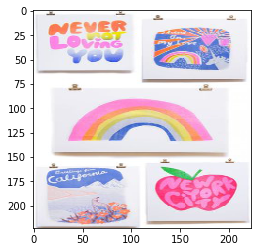

>> Train data..


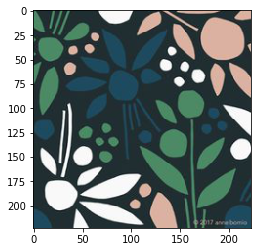

>> Test data..


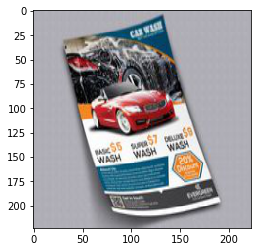

----------------
>> Test data..


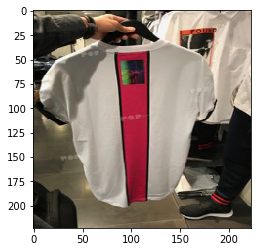

----------------


In [41]:
# 0.2 Visualising data
# --------------------

randrange = list(np.random.randint(x_ae_test.shape[0], size=(1, 2))[0,:])

for i in randrange:
    print('>> Train data..')
    plt.imshow(x_ae_train[i])
    plt.show()
    
for i in randrange:
    print('>> Test data..')
    plt.imshow(x_ae_test[i])
    plt.show()
    print('----------------')

In [42]:
# 0.3 Setting up training data for cmap pointwise fcn ae
# ------------------------------------------------------

x_train_ae_trn = Variable(setup_image_tensor(x_ae_train)).float()
x_test_ae_trn = Variable(setup_image_tensor(x_ae_test)).float()

ae_ht, ae_wd = x_train_ae_trn.size()[2], x_train_ae_trn.size()[3]

print(x_train_ae_trn.size())
print(x_test_ae_trn.size())

torch.Size([2598, 3, 223, 223])
torch.Size([250, 3, 223, 223])


In [43]:
# 0.4 Using an FCN AE system
# --------------------------

#model_ae = fcn_ae()
#model_ae.apply(weights_init)
#model_ae

In [44]:
# 0.5 trainig the model
# ---------------------

''' USE -1 AS EPOCHS TO LOAD SAVED MODEL WITHOUT TRAINING '''

# model_train(xin,yin,xval,yval,load_mode,model,epochs,mbsize,loss_mode,flatten,use_cuda,save_state,path)

cn_file_name = 'ae_model_tboard_3_layer.tar'
cn_save_path = save_path + cn_file_name
print(cn_save_path)


model_ae = model_train(x_train_ae_trn,x_train_ae_trn,None,None,'from saved',None,-1,64,'mse',True,use_cuda,True,cn_save_path)

/Users/venkateshmadhava/Documents/pmate2/pmate2_env/models/ae_model_tboard_3_layer.tar
Input and Output dataset normalised to 0-1
Loading model from saved state...
Last saved loss - 0.0042817373760044575
Last saved epoch - 200


/Users/venkateshmadhava/Documents/pmate2/pmate2_env/lib/python3.5/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


 67%|██████▋   | 2/3 [00:00<00:00, 13.91it/s]

Normalised data to 0-1


100%|██████████| 3/3 [00:00<00:00, 14.62it/s]


Example 0..
----------------------
Original - 


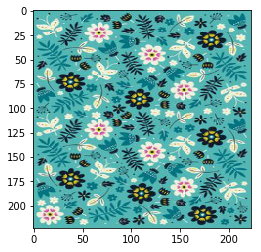

Generated - 


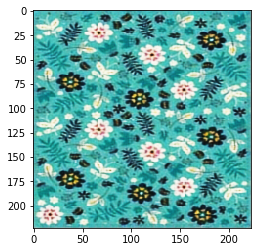


----------------

Example 1..
----------------------
Original - 


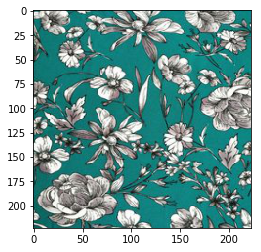

Generated - 


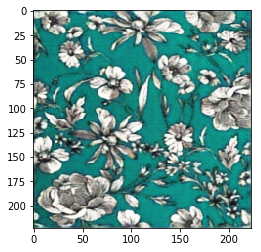


----------------

Example 2..
----------------------
Original - 


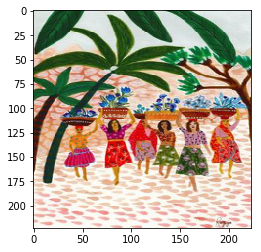

Generated - 


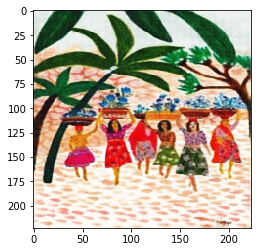


----------------



In [45]:
# 0.6 CHECKING RECONSTRUCTION
# ----------------------------

xo,xg = generate_output(x_test_ae_trn,model_ae,63,66,True,use_cuda)

## 1. Pointwise net set up and training

## 2. Model Ops - only to ensure that the AE model is accurate

In [46]:
# Main settings
# -------------
fcnae_gray_scale = False
concat_mode = 'fcnae' # all,fcnae,pwise
centre_crop_input = True
centre_crop_val = 1.0


# setting ae latent pool mode
# ---------------------------
ae_pool_mode = 'both' # avg and max and both
layer_mode = 'deep' # deep - for all 4 layers, non_deep for 3 layers
layer_dims_set = True
layer_f, layer_s = 9,2 #5,2 ## look at 1/3rd of the image -- that seems to be more accurate
model_ae.set_pool_mode(ae_pool_mode,layer_mode,layer_dims_set,layer_f,layer_s)

Modes set.


### 2.1 Source Ops

1. Setting up data for fcn ae ops..
Done creating dataset of around 638 images. Access them at global x_images_dataset.
>> showing input data before fcn ae inference..
85


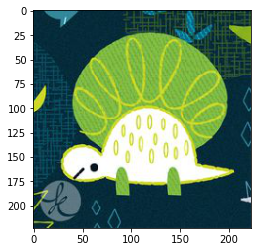

----------------
400


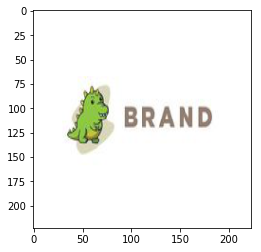

----------------


  0%|          | 3/638 [00:00<00:22, 28.16it/s]

Normalised data to 0-1


100%|██████████| 638/638 [00:53<00:00,  7.32it/s]

torch.Size([638, 51200])


In [47]:
# 2.1 Single ops
# --------------

src_url = parent_url + '/pmate_trendboard/dino_pins'
latents_src_fcnae, x_src = deliver_latents('folder',None,src_url,model_ae,ae_h,ae_w,fcnae_gray_scale,use_cuda,True)


### 2.2 Input ops

1. Setting up data for fcn ae ops..
Done creating dataset of around 2 images. Access them at global x_images_dataset.
>> showing input data before fcn ae inference..
0


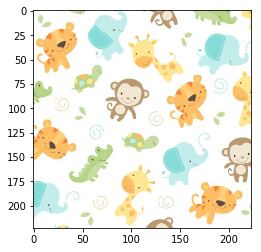

----------------
1


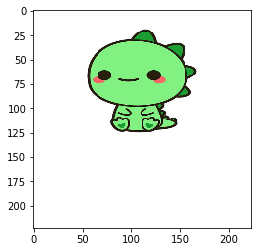

  0%|          | 0/2 [00:00<?, ?it/s]

----------------
Normalised data to 0-1


100%|██████████| 2/2 [00:00<00:00, 21.45it/s]

torch.Size([2, 51200])


In [48]:
# 2.1 Single ops
# --------------

input_url = parent_url + '/pmate_trendboard/trendboard_input/dino_inputs'
latents_inp_fcnae, x_input = deliver_latents('folder',None,input_url,model_ae,ae_h,ae_w,fcnae_gray_scale,use_cuda,True)


### 2.3 comparing ops begins

In [49]:
# 4.1 sanity printing of latent sizes
# -----------------------------------

latents_inp_fcnae.shape, latents_src_fcnae.shape

((2, 51200), (638, 51200))

In [ ]:
#return_similar_images(xin,latents_xin,xrep,latents_xrep,no_suggestions,similarity_check_mode,similarity_check_threshold_value,single_input,print_result)

l,_,_ = return_similar_images(x_input,latents_inp_fcnae,x_src,latents_src_fcnae,5,None,0.5,False,True)

In [ ]:

# input latent ops
# ----------------
x = latents_inp_fcnae[0]
x = x.reshape(x.shape[0],1)

# some set up ops for dot product
# -------------------------------
temp_x = np.zeros((x.shape[0],latents_src_fcnae.shape[0]))
temp_x[:,:] = x

# dot product
# ----------
dot_prod = np.dot(temp_x,latents_src_fcnae)

# L2 norm of vecs
# ---------------
temp_x_l2 = np.sqrt(np.sum(np.square(temp_x)))
latents_src_fcnae_l2 = np.sqrt(np.sum(np.square(latents_src_fcnae)))


ValueError: shapes (51200,1) and (638,51200) not aligned: 1 (dim 1) != 638 (dim 0)

array([0.00334849, 0.00320697, 0.00244859, ..., 0.01134173, 0.01855761,
       0.01855761])

In [ ]:
# END OF MODEL OPS

# 3. Dynamic pinterest ops

In [ ]:
# Main model settings
#####################

fcnae_gray_scale = False
concat_mode = 'fcnae' # all,fcnae,pwise
centre_crop_input = True
centre_crop_val = 1.0


# setting ae latent pool mode
#############################

ae_pool_mode = 'both' # avg and max and both
layer_mode = 'deep' # deep - for all 4 layers, non_deep for 3 layers
layer_dims_set = True
layer_f, layer_s = 9,2 #5,2 # 7,2 and both worked nice
model_ae.set_pool_mode(ae_pool_mode,layer_mode,layer_dims_set,layer_f,layer_s)

### 3.1 creating recursive related images ops

In [ ]:
# Main recursive scrapping settings here
########################################

user_in = 'food'
single_input = True
user_input_url = parent_url + '/pmate_trendboard/trendboard_input/food_inputs'
ins_obj = Inspiration(user_in,user_input_url,1,model_ae,ae_h,ae_w,single_input,use_cuda)


In [ ]:
# calling the class function
# --------------------------

ins_obj.run_parse()

In [ ]:
# Snippet to save results
# ------------------------

outurl = '/Users/venkateshmadhava/Desktop/t_pins/'

for i in range(ins_obj.final_results.shape[0]):
    name = str(i) + '.jpg'
    scipy.misc.imsave(outurl + name, ins_obj.final_results[i])

# rough